# Prepare Dataset
https://www.kaggle.com/code/humamfauzi/multiple-stock-prediction-using-single-nn#Gated-Recurrent-Units


In [1]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
config = {
    'data_source': 'grouped',
    'companies': ['AAPL', 'MSFT', 'GOOG', 'NVDA', 'META', 'AMZN', 'TSLA', 'NFLX'],
    'seq_len': 50
}

In [3]:
# stock dataframe
df_stocks = pd.read_csv("/content/drive/MyDrive/Financial Analysis/stocks.csv", encoding='utf-16')
df_stocks = df_stocks.drop(['Adj Close', 'Volume'], axis=1)

if config['data_source'] == 'processed':
    df_news = pd.read_csv("/content/drive/MyDrive/Financial Analysis/processed.csv")
    df_grouped = df_news.groupby(['date', 'symbol']).agg(sentiment=('sentiment', pd.Series.mode)).reset_index()
elif config['data_source'] == 'grouped':
    df_grouped = pd.read_csv("/content/drive/MyDrive/Financial Analysis/grouped.csv")

# sentiment grouped by date and company
# sentiment determined by the mode
df_grouped = df_grouped.rename(columns={'date': 'Date', 'symbol': 'Ticker', 'sentiment': 'Sentiment'})

In [4]:
df_stocks

Date Ticker        Close         High          Low         Open
0        2009-01-02      A    10.363297    10.401585     9.897459     9.954891
1        2009-01-02   AAPL     2.730994     2.739722     2.562771     2.584438
2        2009-01-02    ABT    17.675549    17.771253    17.282833    17.665649
3        2009-01-02   ACGL     7.287052     7.395878     7.226829     7.395878
4        2009-01-02    ACN    25.077682    25.174508    24.236052    24.236052
...             ...    ...          ...          ...          ...          ...
1897644  2024-12-30    YUM   132.892029   133.777842   132.374470   133.499160
1897645  2024-12-30    ZBH   105.174667   106.122633   104.426271   105.823279
1897646  2024-12-30   ZBRA   383.850006   386.959991   378.149994   385.059998
1897647  2024-12-30    ZTS   161.751007   163.555549   160.963380   163.396028
1897648  2024-12-30  ^GSPC  5906.939941  5940.790039  5869.160156  5920.669922

[1897649 rows x 6 columns]

In [5]:
# if more than 1 mode, choose appropriate sentiment

sentiment_mapping = {
    "['negative' 'neutral' 'positive']": 'neutral',
    "['negative' 'neutral']": 'negative',
    "['negative' 'positive']": 'neutral',
    "['neutral' 'positive']": 'positive'
}

df_grouped['Sentiment'] = df_grouped['Sentiment'].map(lambda x: sentiment_mapping[x] if x in sentiment_mapping else x)

In [6]:
# join stocks and news sentiment on date
df_join = df_stocks.merge(df_grouped, on=['Date', 'Ticker'], how='left').set_index('Date')
df_join.index = pd.to_datetime(df_join.index)

In [7]:
# filter for specific company
df = df_join[df_join['Ticker'].isin(config['companies'])]
# sentiment is neutral if no sentiment
df = df.fillna('neutral')
print(df)
print(df['Sentiment'].value_counts())

           Ticker       Close        High         Low        Open Sentiment
Date                                                                       
2009-01-02   AAPL    2.730994    2.739722    2.562771    2.584438   neutral
2009-01-02   AMZN    2.718000    2.726500    2.553500    2.567500   neutral
2009-01-02   GOOG    7.965276    7.977671    7.573111    7.649957   neutral
2009-01-02   MSFT   14.924774   14.976163   14.220014   14.337474   neutral
2009-01-02   NFLX    4.267143    4.357143    4.200000    4.217143   neutral
...           ...         ...         ...         ...         ...       ...
2024-12-30   META  590.714417  596.409362  585.059475  588.226640   neutral
2024-12-30   MSFT  423.979858  426.694417  421.055729  425.207408   neutral
2024-12-30   NFLX  900.429993  908.229980  889.710022  894.510010   neutral
2024-12-30   NVDA  137.477356  140.257099  134.007674  134.817597   neutral
2024-12-30   TSLA  417.410004  427.000000  415.750000  419.399994   neutral

[30975 rows

In [8]:
from sklearn.preprocessing import OrdinalEncoder

# encode company and sentiment to numeric
categorical_columns = ['Ticker', 'Sentiment']
enc = OrdinalEncoder()
df[categorical_columns] = enc.fit_transform(df[categorical_columns])
print(enc.categories_)
df

[array(['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NFLX', 'NVDA', 'TSLA'],
      dtype=object), array(['negative', 'neutral', 'positive'], dtype=object)]


Ticker       Close        High         Low        Open  Sentiment
Date                                                                         
2009-01-02     0.0    2.730994    2.739722    2.562771    2.584438        1.0
2009-01-02     1.0    2.718000    2.726500    2.553500    2.567500        1.0
2009-01-02     2.0    7.965276    7.977671    7.573111    7.649957        1.0
2009-01-02     4.0   14.924774   14.976163   14.220014   14.337474        1.0
2009-01-02     5.0    4.267143    4.357143    4.200000    4.217143        1.0
...            ...         ...         ...         ...         ...        ...
2024-12-30     3.0  590.714417  596.409362  585.059475  588.226640        1.0
2024-12-30     4.0  423.979858  426.694417  421.055729  425.207408        1.0
2024-12-30     5.0  900.429993  908.229980  889.710022  894.510010        1.0
2024-12-30     6.0  137.477356  140.257099  134.007674  134.817597        1.0
2024-12-30     7.0  417.410004  427.000000  415.750000  419.399994        1.0

[30975 rows x 6 columns]

In [9]:
company_mapping = {}
for i in range(len(enc.categories_[0])):
    company_mapping[enc.categories_[0][i]] = i
company_mapping

{'AAPL': 0,
 'AMZN': 1,
 'GOOG': 2,
 'META': 3,
 'MSFT': 4,
 'NFLX': 5,
 'NVDA': 6,
 'TSLA': 7}

In [10]:
# split dataframe into indiviudal df based on company
df_dict = {}
for company, encoding in company_mapping.items():
    df_dict[company] = df[df['Ticker'] == encoding]

In [11]:
# split dataframe into train and test
def train_test_split(df):
    training_size = int(len(df) * 0.8)
    train = df[:training_size]
    test = df[training_size:]
    assert(len(train) + len(test) == len(df))
    return train, test

# further divide each company's df into train and test
for company, df in df_dict.items():
    train, test = train_test_split(df)
    df_dict[company] = {'train': train, 'test': test}

In [12]:
df_dict

{'AAPL': {'train':             Ticker       Close        High         Low        Open  Sentiment
  Date                                                                         
  2009-01-02     0.0    2.730994    2.739722    2.562771    2.584438        1.0
  2009-01-05     0.0    2.846252    2.894402    2.789977    2.803821        1.0
  2009-01-06     0.0    2.799307    2.924195    2.780348    2.887481        1.0
  2009-01-07     0.0    2.738818    2.783657    2.716248    2.762893        1.0
  2009-01-08     0.0    2.789677    2.803220    2.709628    2.721365        1.0
  ...            ...         ...         ...         ...         ...        ...
  2021-10-11     0.0  140.149490  142.112231  139.168120  139.619557        1.0
  2021-10-12     0.0  138.873764  140.581354  138.412519  140.561723        1.0
  2021-10-13     0.0  138.284897  138.765759  136.606747  138.608751        1.0
  2021-10-14     0.0  141.081818  141.199592  138.873734  139.462562        1.0
  2021-10-15     0.0  1

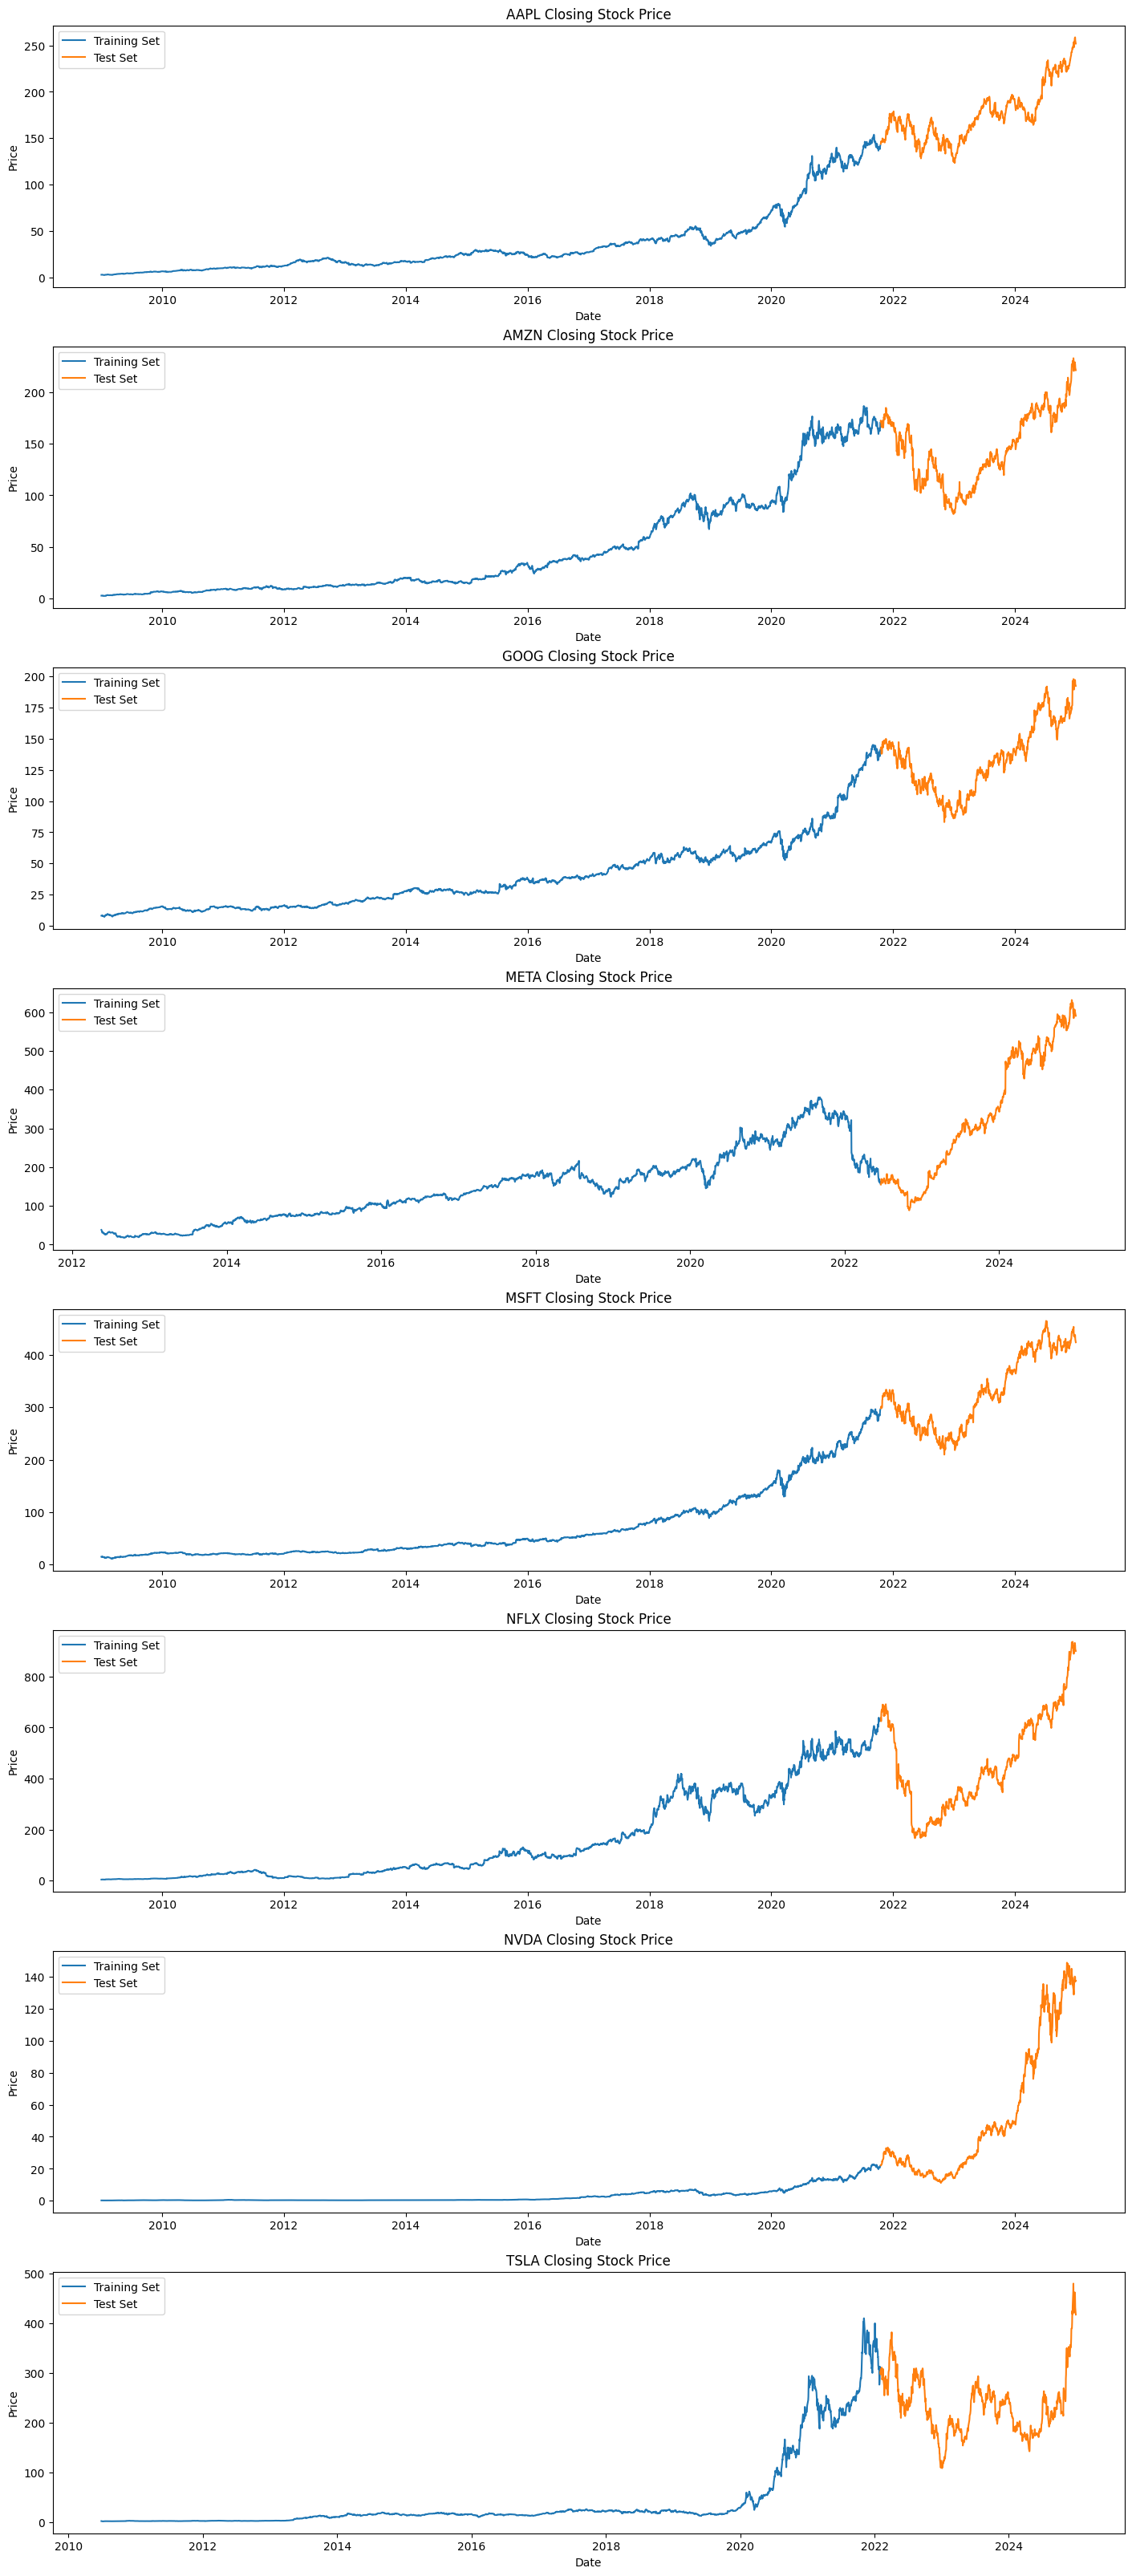

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)
for i, company in enumerate(df_dict):
    axs[i].plot(df_dict[company]['train'].index, df_dict[company]['train']['Close'])
    axs[i].plot(df_dict[company]['test'].index, df_dict[company]['test']['Close'])
    axs[i].set_title(f'{company} Closing Stock Price')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Price')
    axs[i].legend(["Training Set", "Test Set"])

# Deep Learning (LSTM)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# scale numeric columns for each company, as LSTM works better with normalized data
# store the scaler

scaler_dict = {}
df_scaled_dict = {}
numerical_columns = ['Close', 'High', 'Low', 'Open']

for company in df_dict:
    scaler = MinMaxScaler(feature_range=(0,1))
    train = df_dict[company]['train'].copy()
    test = df_dict[company]['test'].copy()
    train[numerical_columns] = scaler.fit_transform(train[numerical_columns])
    test[numerical_columns] = scaler.transform(test[numerical_columns])
    df_scaled_dict[company] = {'train': train, 'test': test}
    scaler_dict[company] = scaler

In [ ]:
df_scaled_dict

{'AAPL': {'train':             Ticker     Close      High       Low      Open  Sentiment
  Date                                                                 
  2009-01-02     0.0  0.002494  0.001791  0.001404  0.001288        1.0
  2009-01-05     0.0  0.003255  0.002810  0.002927  0.002734        1.0
  2009-01-06     0.0  0.002945  0.003006  0.002863  0.003286        1.0
  2009-01-07     0.0  0.002546  0.002081  0.002433  0.002464        1.0
  2009-01-08     0.0  0.002882  0.002210  0.002389  0.002191        1.0
  ...            ...       ...       ...       ...       ...        ...
  2021-10-11     0.0  0.910040  0.919545  0.917232  0.904818        1.0
  2021-10-12     0.0  0.901615  0.909464  0.912167  0.911030        1.0
  2021-10-13     0.0  0.897726  0.897509  0.900060  0.898153        1.0
  2021-10-14     0.0  0.916198  0.913535  0.915259  0.903782        1.0
  2021-10-15     0.0  0.923198  0.920127  0.928417  0.914524        1.0
  
  [3220 rows x 6 columns],
  'test':        

In [ ]:
# use sliding window of size seq_len to create sequential data, where input is seq_len data and output is next day close price
def create_dataset(dataset, seq_len):
    X = []
    y = []
    for i in range(len(dataset) - seq_len):
        X.append(dataset.iloc[i:i + seq_len])
        y.append(dataset.iloc[i + seq_len]['Close'])
    return np.array(X), np.array(y)

In [ ]:
X_train_dict, y_train_dict, X_test_dict, y_test_dict = {}, {}, {}, {}
# keep track of size for input output dataset
dataset_shape_df = {'X_train':[], 'y_train':[], 'X_test':[], 'y_test':[]}

# create dataset for train and test for each company
for company in df_scaled_dict:
    X_train, y_train = create_dataset(df_scaled_dict[company]['train'], config['seq_len'])
    X_test, y_test = create_dataset(df_scaled_dict[company]['test'], config['seq_len'])
    X_train_dict[company] = X_train
    y_train_dict[company] = y_train
    X_test_dict[company] = X_test
    y_test_dict[company] = y_test
    dataset_shape_df['X_train'].append(X_train.shape)
    dataset_shape_df['y_train'].append(y_train.shape)
    dataset_shape_df['X_test'].append(X_test.shape)
    dataset_shape_df['y_test'].append(y_test.shape)

In [ ]:
pd.DataFrame(dataset_shape_df, index=df_scaled_dict.keys())

X_train  y_train        X_test  y_test
AAPL  (3170, 50, 6)  (3170,)  (755, 50, 6)  (755,)
AMZN  (3170, 50, 6)  (3170,)  (755, 50, 6)  (755,)
GOOG  (3170, 50, 6)  (3170,)  (755, 50, 6)  (755,)
META  (2489, 50, 6)  (2489,)  (585, 50, 6)  (585,)
MSFT  (3170, 50, 6)  (3170,)  (755, 50, 6)  (755,)
NFLX  (3170, 50, 6)  (3170,)  (755, 50, 6)  (755,)
NVDA  (3170, 50, 6)  (3170,)  (755, 50, 6)  (755,)
TSLA  (2870, 50, 6)  (2870,)  (681, 50, 6)  (681,)

In [ ]:
# combine all training samples
X_train = np.concatenate([X_train_dict[company] for company in X_train_dict], axis=0)
y_train = np.concatenate([y_train_dict[company] for company in y_train_dict], axis=0)

print(X_train.shape)
print(y_train.shape)

(24379, 50, 6)
(24379,)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Input, Dense, Dropout

# define LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 50, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,417 (1.27 MB)

 Trainable params: 332,417 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train model
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    verbose=1
)

Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0216 - val_loss: 6.7271e-04
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.2600e-04 - val_loss: 6.7828e-04
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.8546e-04 - val_loss: 4.4989e-04
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.6641e-04 - val_loss: 4.1144e-04
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.3798e-04 - val_loss: 3.6247e-04
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.6148e-04 - val_loss: 3.5548e-04
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.1787e-04 - val_loss: 4.7150e-04
Epoch 8/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.0093e-04 - val_loss: 2.3709e-04
Epoch 9/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.9357e-04 - val_loss: 3.5059e-04
Epoch 10/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.8599e-04 - val_loss: 2.0420e-04
Epoch 11/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 5

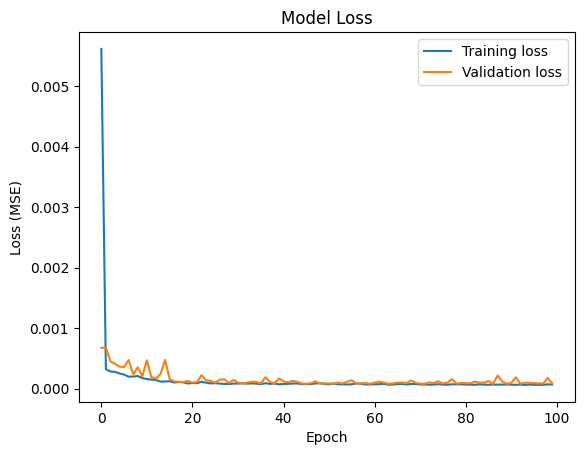

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
53.764252309722835
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11.943153503606679
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
10.742633856257655
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
331.136818299836
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
169.26008122526926
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
257.086393103151
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1686.659636802596
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86.28485716115618


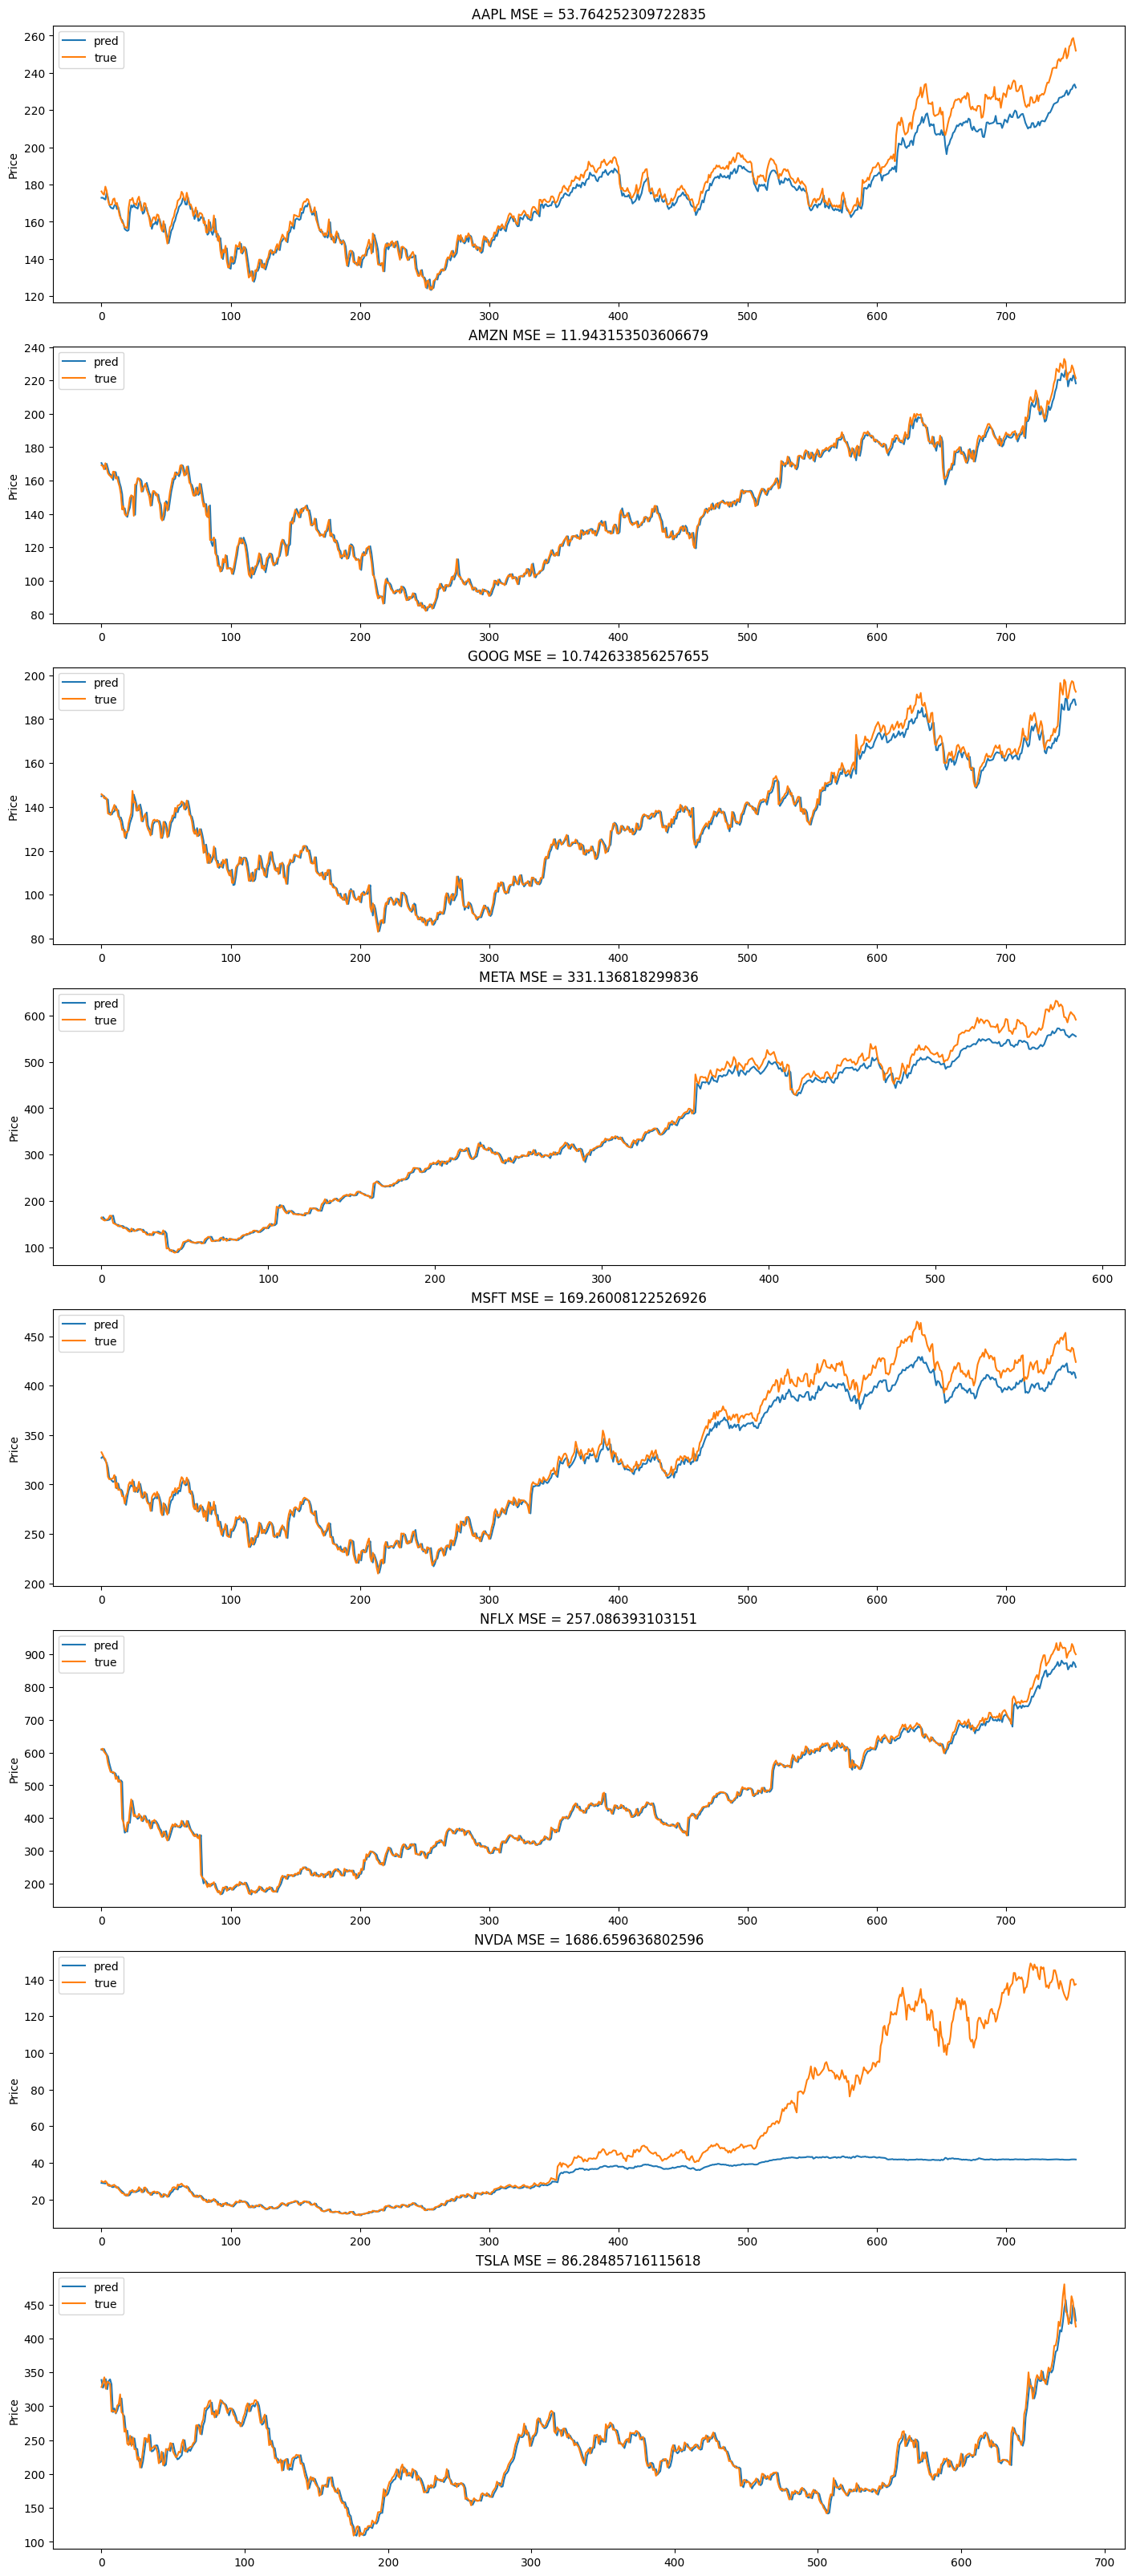

In [ ]:
from sklearn.metrics import mean_squared_error

fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)

# visualize prediction by unscaling the data
for i, company in enumerate(df_scaled_dict):
    scaler = scaler_dict[company]
    y_pred = model.predict(X_test_dict[company]).flatten()
    y_true = y_test_dict[company]
    # create dummy input matrix since we originally scaled on a matrix
    dummy_pred = np.zeros(shape=(len(y_pred), 4))
    dummy_pred[:, 0] = y_pred
    dummy_true = np.zeros(shape=(len(y_true), 4))
    dummy_true[:, 0] = y_true
    y_pred_scaled = scaler.inverse_transform(dummy_pred)[:, 0]
    y_true_scaled = scaler.inverse_transform(dummy_true)[:, 0]
    MSE = mean_squared_error(y_pred_scaled, y_true_scaled)
    print(MSE)

    axs[i].plot(y_pred_scaled)
    axs[i].plot(y_true_scaled)
    axs[i].set_title(f'{company} MSE = {MSE}')
    # axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Price')
    axs[i].legend(["pred", "true"])

# Statistical Models (ARIMA)
https://machinelearningmastery.com/time-series-data-stationary-python/

Check for Stationarity

1. Visual Inspection

Based on visual inspection, there is an upward trend in the time series data, but no seasonality

2. Summary Statistics Over Time Windows

The mean and variance of the first half and second half of each time series differ significantly, indicating non-stationary


In [ ]:
# split dataset into half and compare mean andd variance

for company in df_dict:
    n = len(df_dict[company]['train']['Close'])
    X1 = df_dict[company]['train']['Close'][:n // 2]
    X2 = df_dict[company]['train']['Close'][n // 2:]
    print(company)
    print(f"mean1: {X1.mean()}, mean2: {X2.mean()}")
    print(f"var1: {X1.var()}, var2: {X2.var()}")

AAPL
mean1: 13.504341824306465, mean2: 57.56026335295683
var1: 44.30937808824459, var2: 1377.7990873211488
AMZN
mean1: 11.118474538133752, mean2: 83.95012563622517
var1: 22.741924274905738, var2: 2255.9841668562294
GOOG
mean1: 17.91597518447023, mean2: 60.22829877012265
var1: 39.4464636478331, var2: 714.4065852718378
META
mean1: 75.86253056327033, mean2: 219.39752870694858
var1: 1425.815449123322, var2: 3984.877445050212
MSFT
mean1: 24.929502135330104, mean2: 116.44676125567892
var1: 52.77199632642527, var2: 4981.271554684853
NFLX
mean1: 28.475344238222014, mean2: 289.6763865974379
var1: 431.21060758960886, var2: 24317.282622552255
NVDA
mean1: 0.3529142199465947, mean2: 6.065884967712882
var1: 0.00742506182679545, var2: 27.819342682913284
TSLA
mean1: 7.897120532924181, mean2: 78.57693512929629
var1: 39.11023071609761, var2: 10034.50863559441


3. Augmented Dickey-Fuller (ADF) Test

The p-value for all time series is > 0.05, meaning we cannot reject the null hypothesis of non-stationary. Therefore, the time series are non-stationary under the ADF test.



In [ ]:
from statsmodels.tsa.stattools import adfuller

for company in df_dict:
    X = df_dict[company]['train']['Close']
    result = adfuller(X)
    print(company)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

AAPL
ADF Statistic: 2.549373
p-value: 0.999064
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
AMZN
ADF Statistic: 2.137283
p-value: 0.998827
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
GOOG
ADF Statistic: 4.260522
p-value: 1.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
META
ADF Statistic: -1.539903
p-value: 0.513688
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
MSFT
ADF Statistic: 6.549447
p-value: 1.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
NFLX
ADF Statistic: 1.916811
p-value: 0.998555
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
NVDA
ADF Statistic: 5.190811
p-value: 1.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
TSLA
ADF Statistic: 1.360874
p-value: 0.996929
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Since the data is not stationary, we need to
- find the order of difference we need to apply to produce constant mean
- use boxcox transform to transform into normal distribution to produce constant variance

In [ ]:
from statsmodels.tsa.statespace.tools import diff
from scipy.stats import boxcox

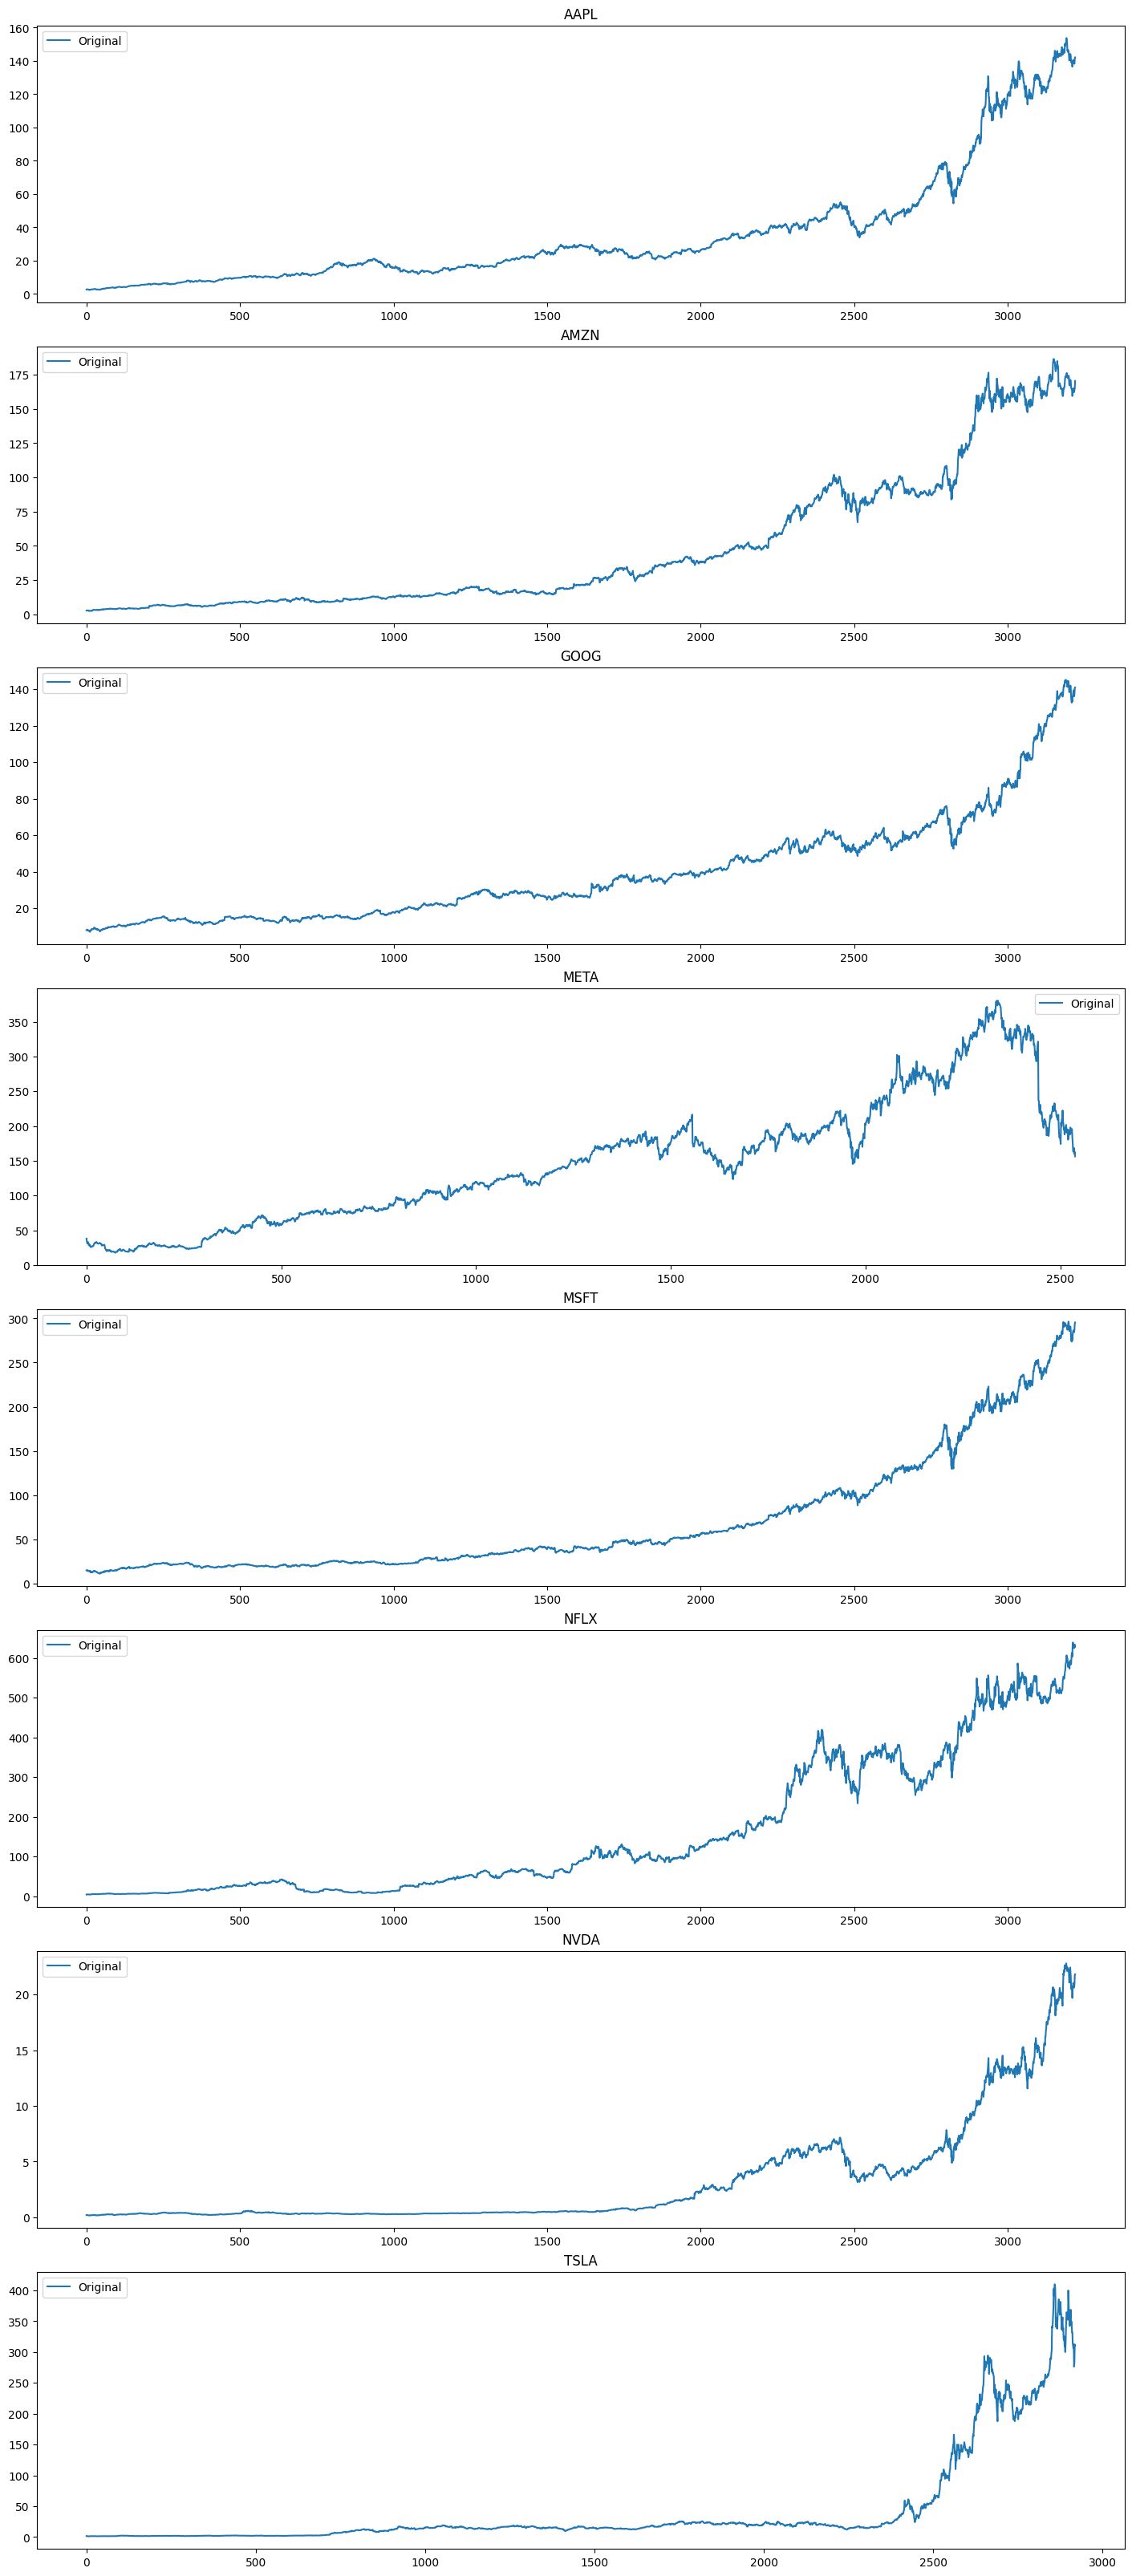

In [ ]:
fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)
for i, company in enumerate(df_dict):
    X = df_dict[company]['train']['Close'].to_numpy()
    axs[i].plot(X, label="Original")

    axs[i].set_title(f'{company}')
    axs[i].legend()

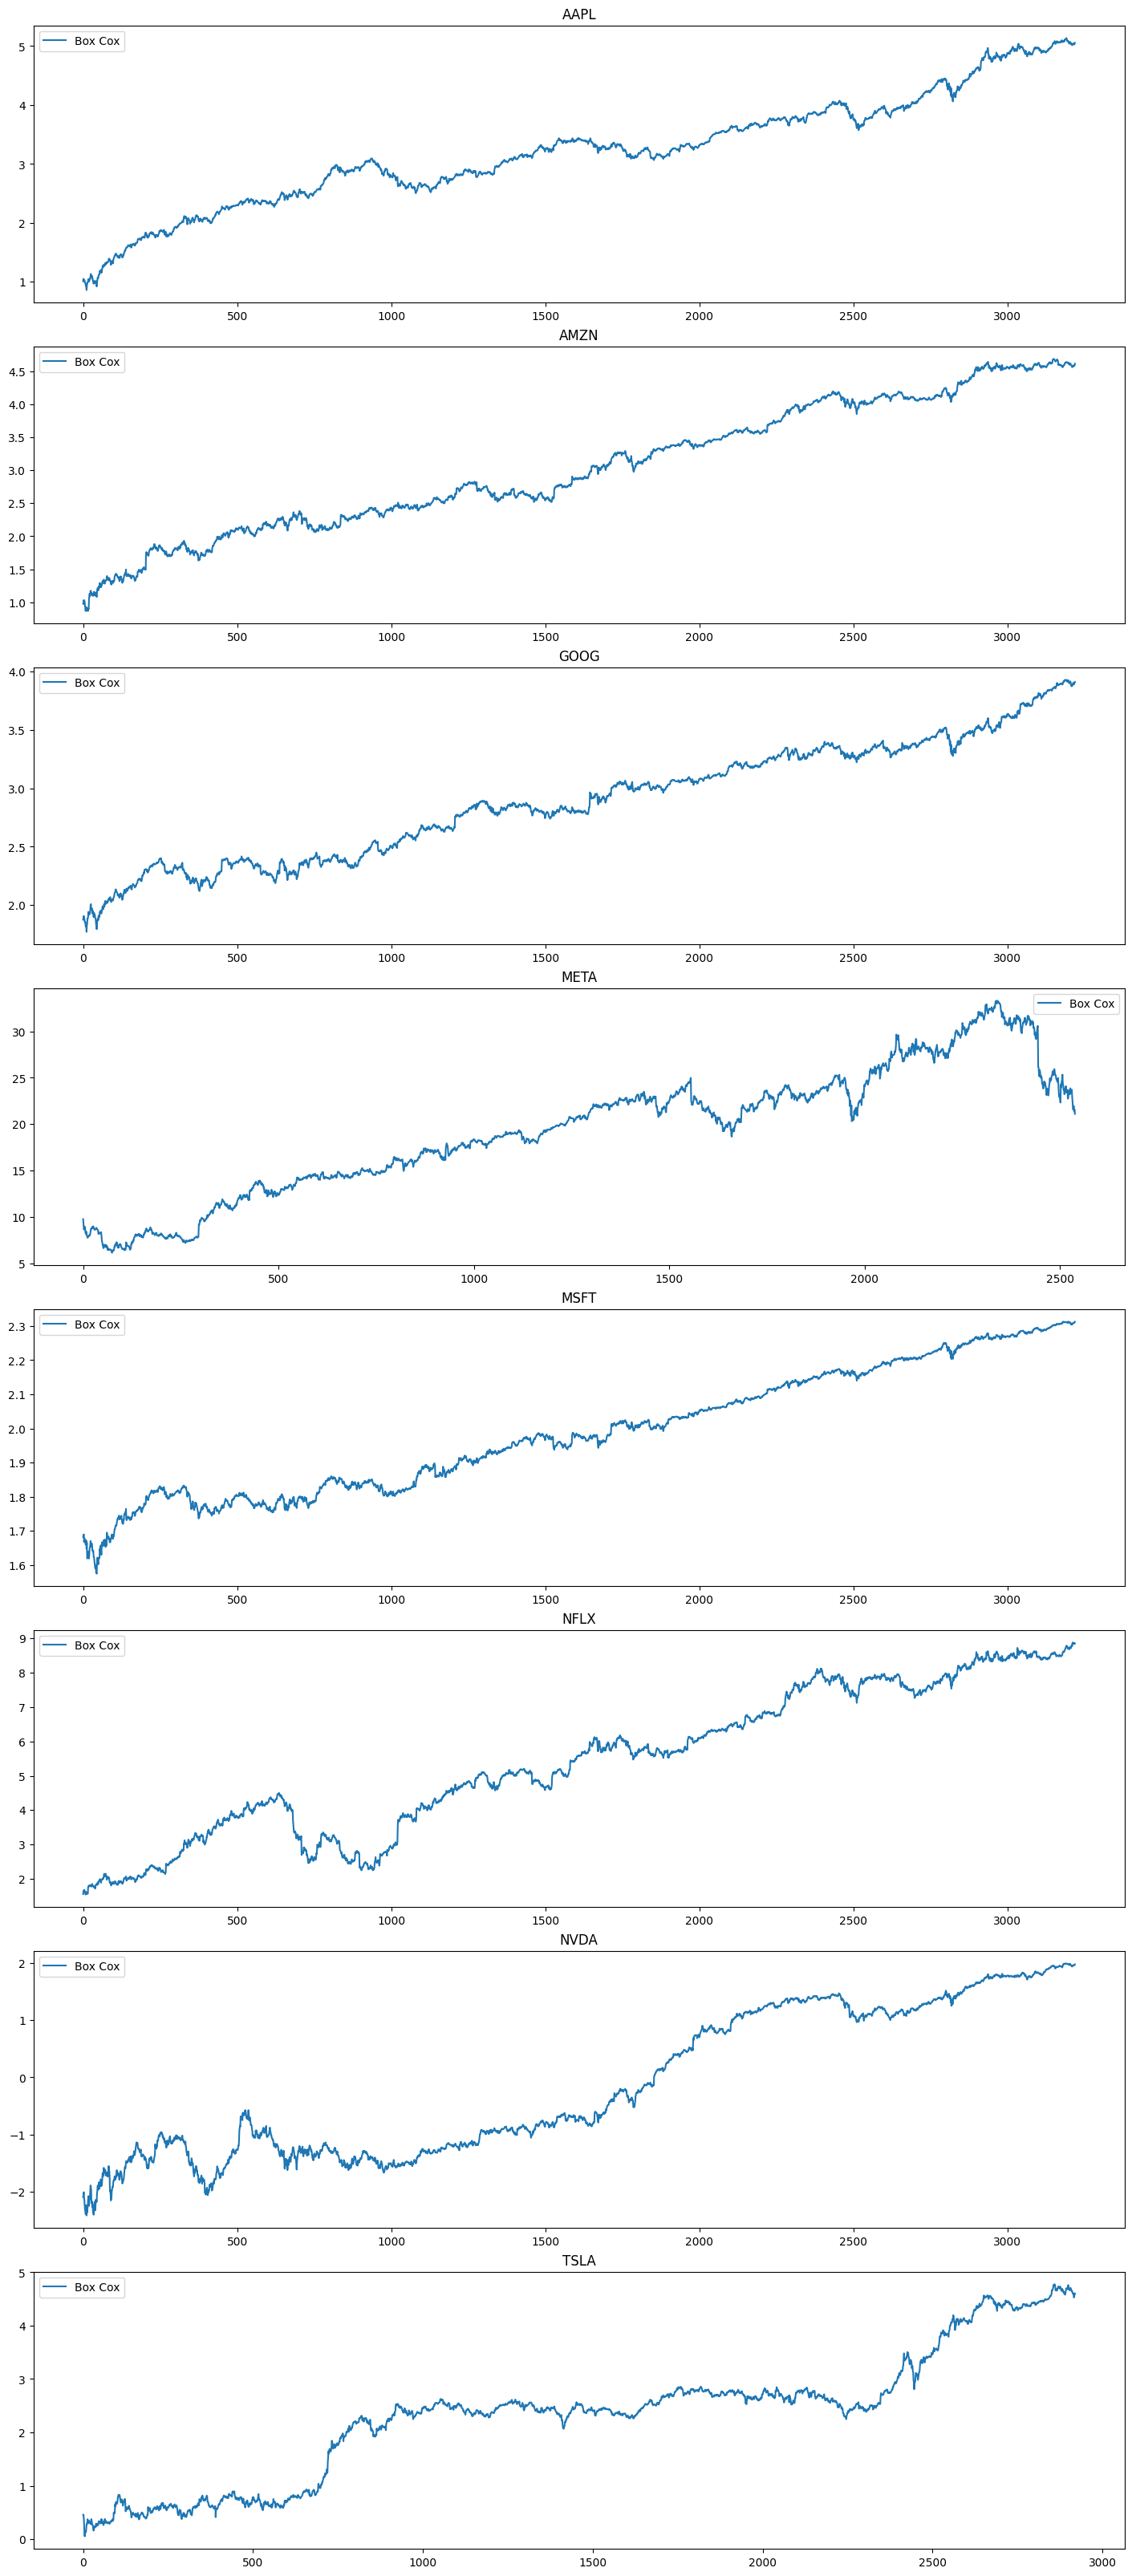

In [ ]:
fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)
for i, company in enumerate(df_dict):
    X = df_dict[company]['train']['Close']
    X_boxcox, _ = boxcox(X)
    axs[i].plot(X_boxcox, label="Box Cox")

    axs[i].set_title(f'{company}')
    axs[i].legend()

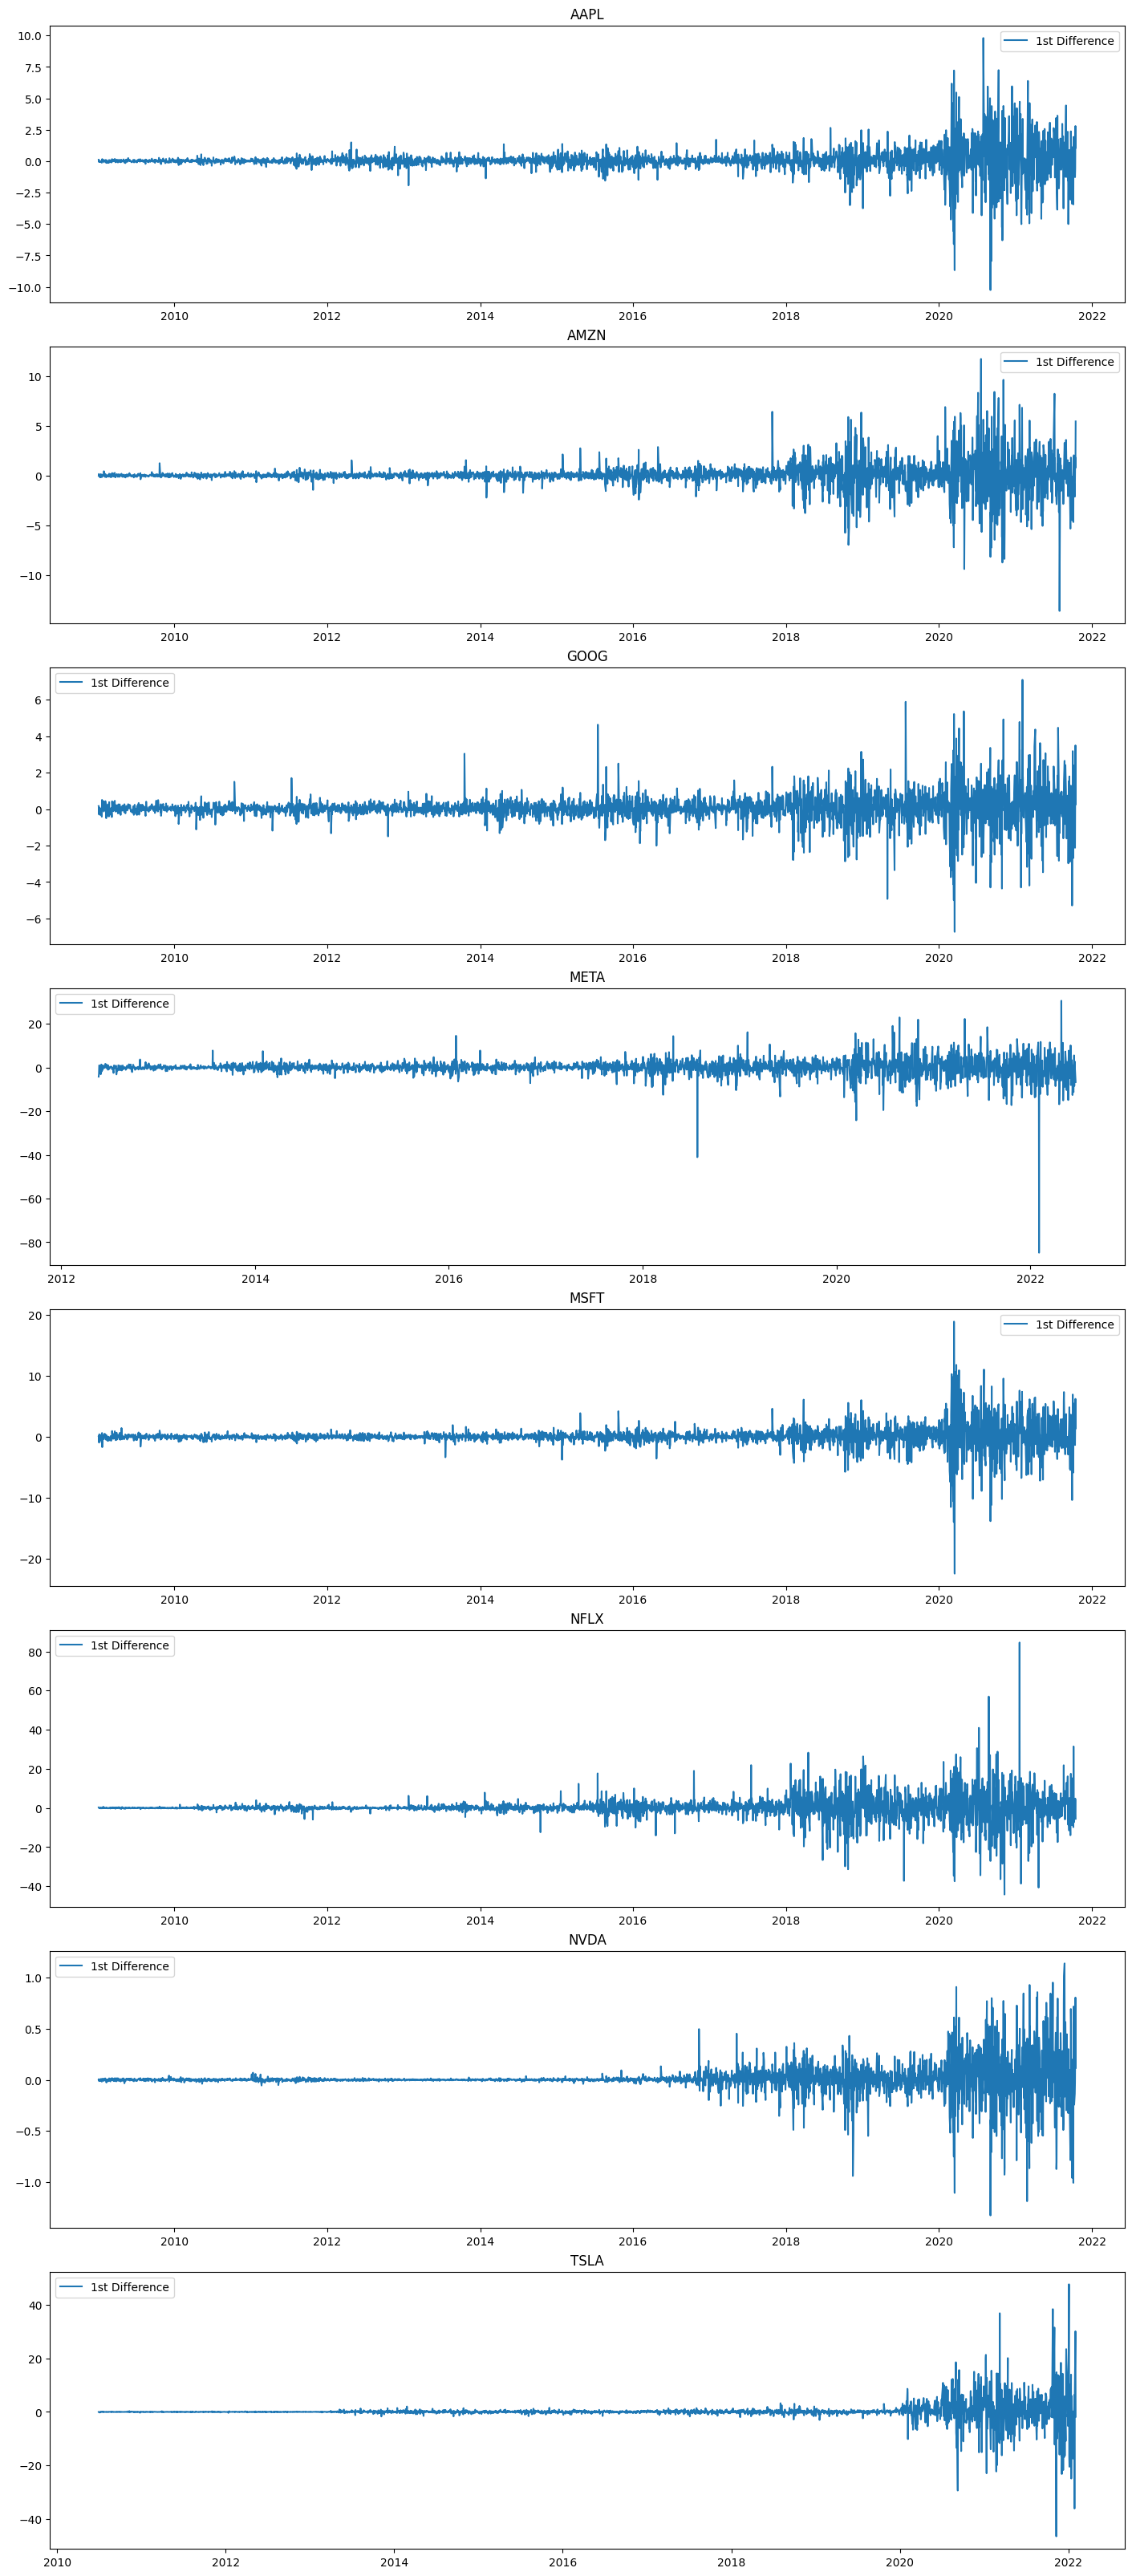

In [ ]:
fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)
for i, company in enumerate(df_dict):
    X = df_dict[company]['train']['Close']
    X_boxcox, _ = boxcox(X)
    X_diff = diff(X, k_diff=1)
    axs[i].plot(X_diff, label="1st Difference")

    axs[i].set_title(f'{company}')
    axs[i].legend()

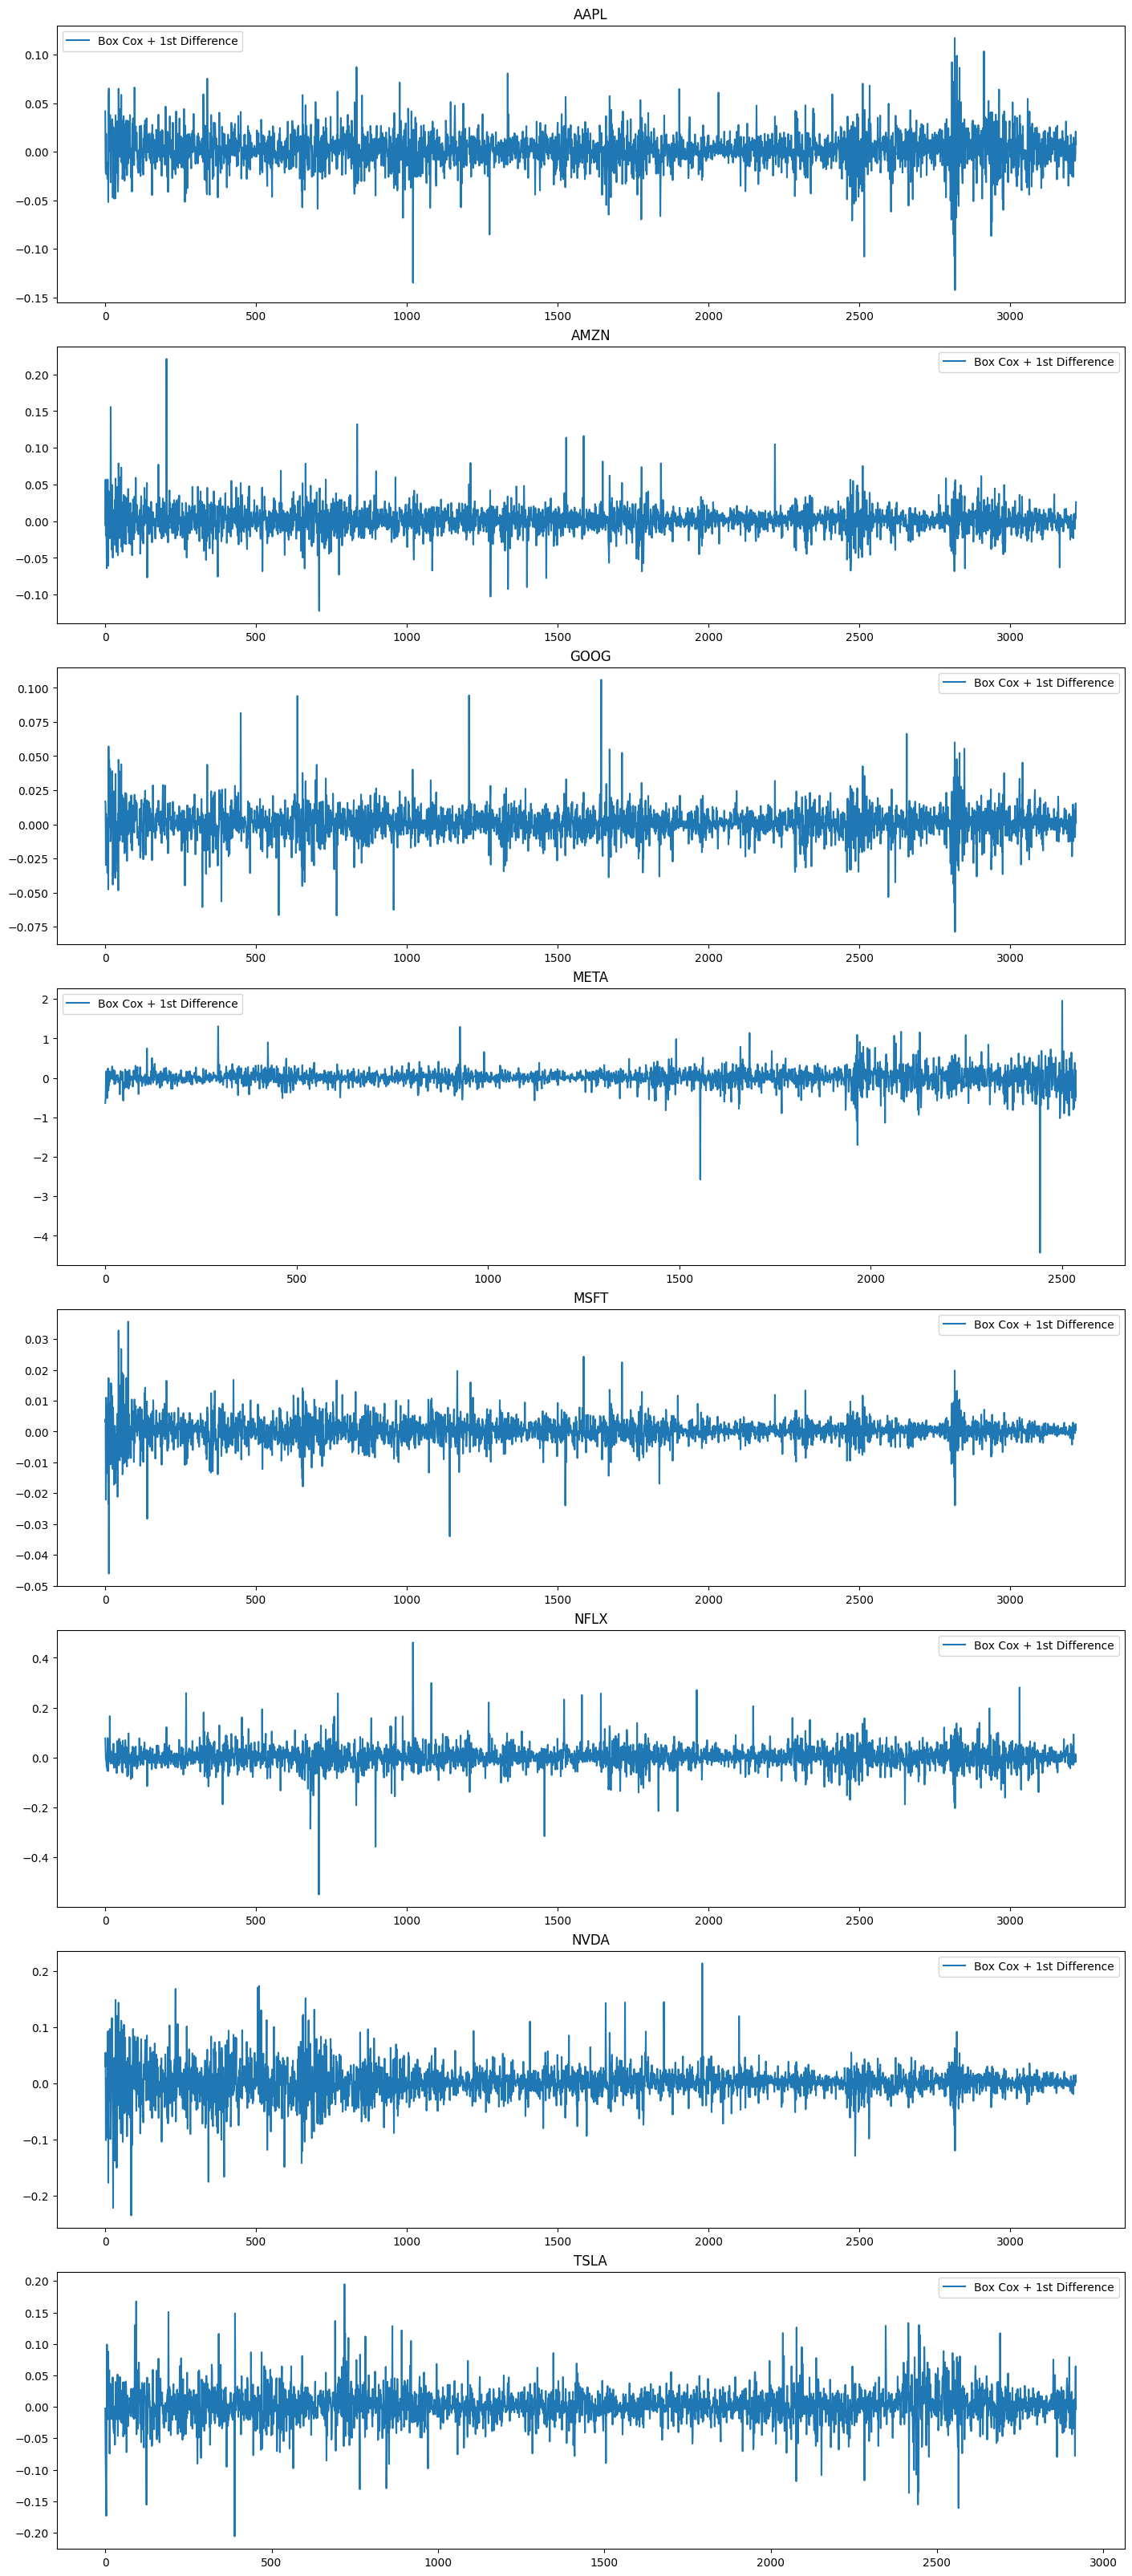

In [ ]:
fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)
for i, company in enumerate(df_dict):
    X = df_dict[company]['train']['Close']
    X_boxcox, _ = boxcox(X)
    X_boxcox_diff = diff(X_boxcox, k_diff=1)
    axs[i].plot(X_boxcox_diff, label="Box Cox + 1st Difference")

    axs[i].set_title(f'{company}')
    axs[i].legend()

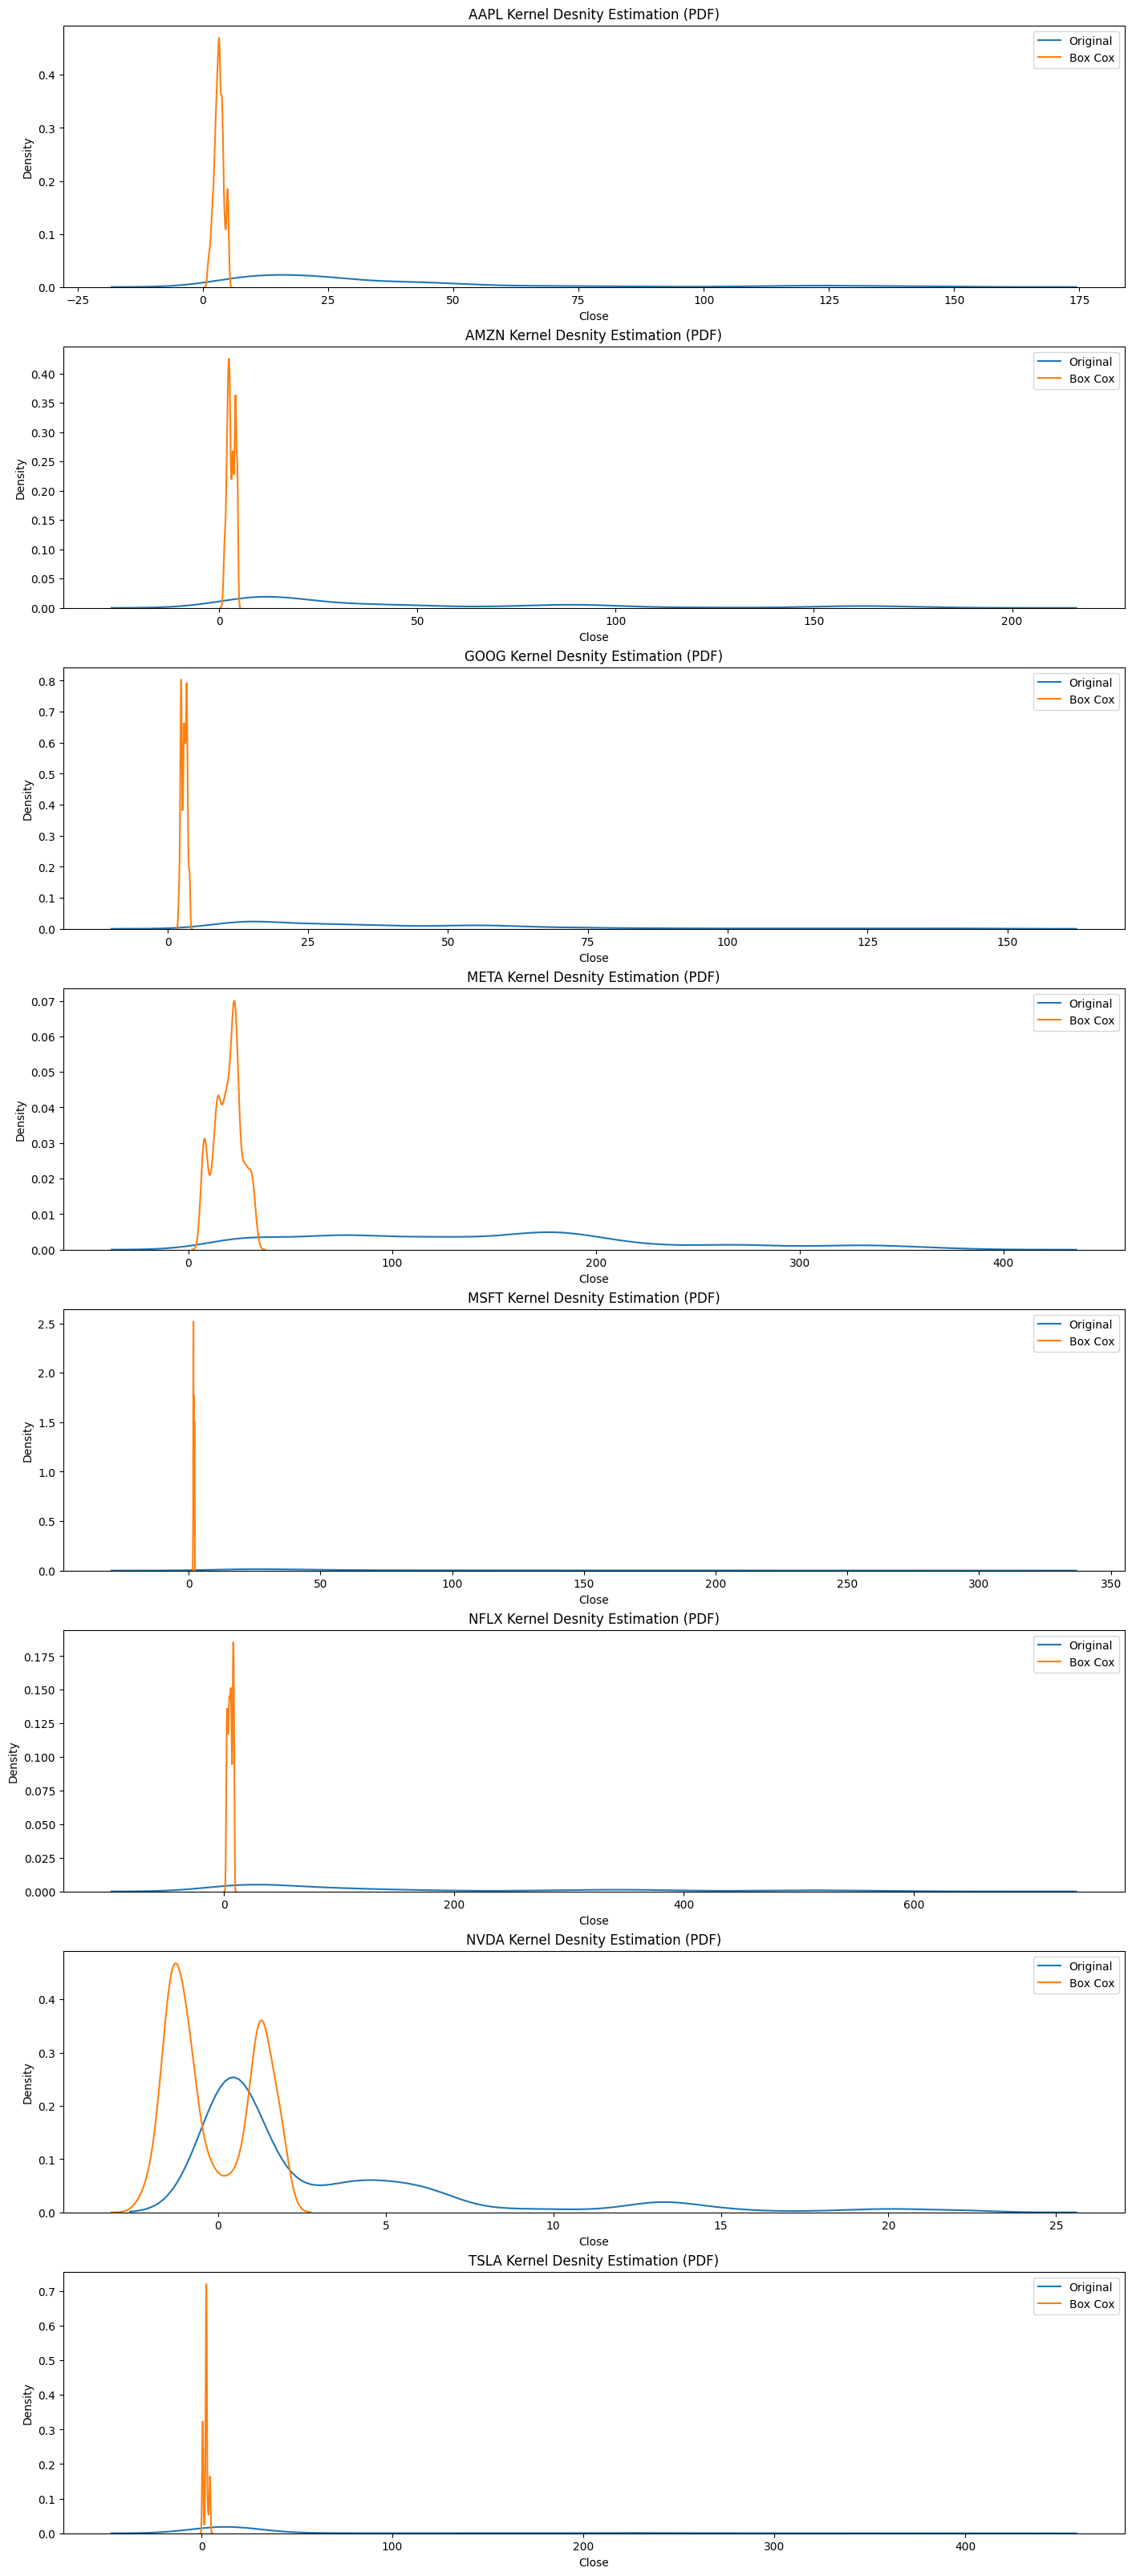

In [ ]:
from scipy.stats import boxcox
import seaborn as sns

fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)
for i, company in enumerate(df_dict):
    X = df_dict[company]['train']['Close']
    # boxcox transform
    X_boxcox, _ = boxcox(X)

    sns.kdeplot(X, ax=axs[i])
    sns.kdeplot(X_boxcox, ax=axs[i])
    axs[i].set_title(f'{company} Kernel Desnity Estimation (PDF)')
    axs[i].legend(['Original', 'Box Cox'])

To find the orders of the autoregressive and moving average model, we look at the autocorrelation and partial autocorrelation plot. We can see the points are no longer significant after 8. So the order of p and q is 8.

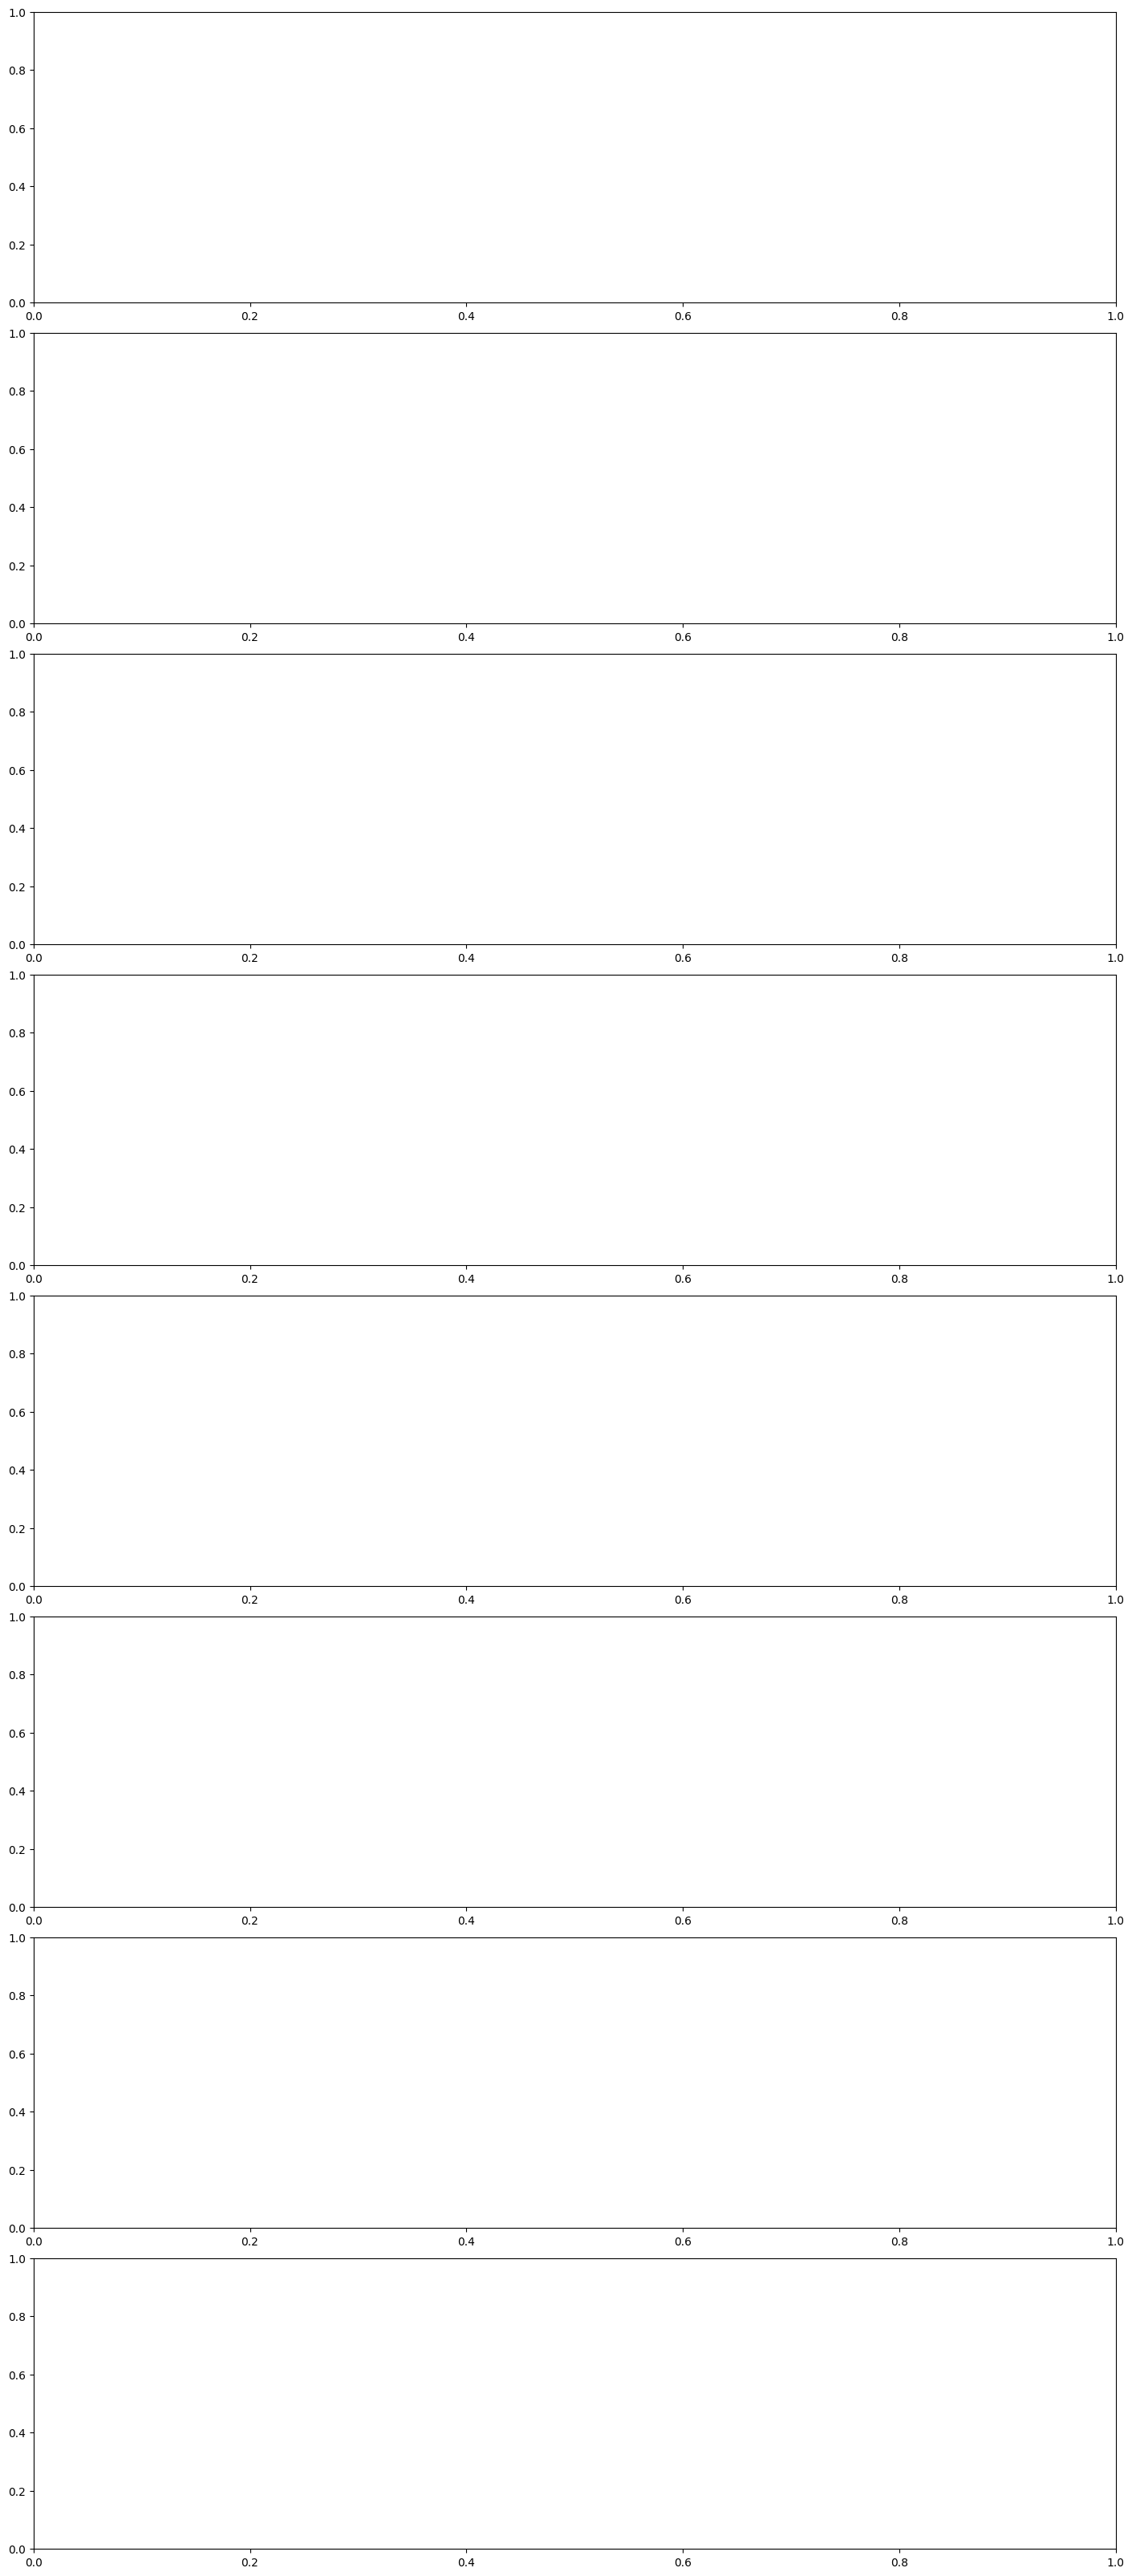

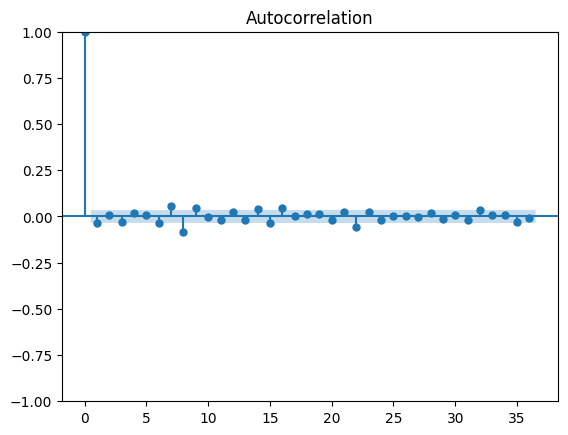

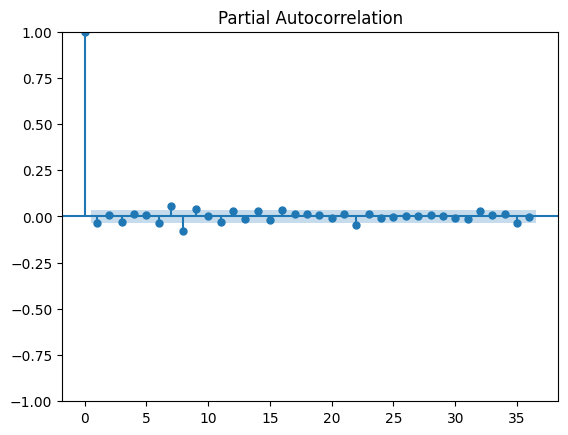

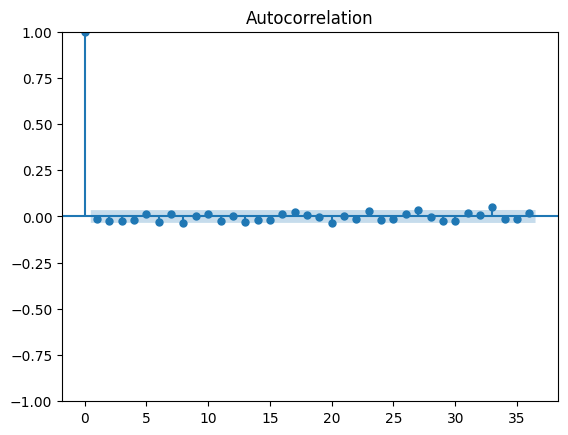

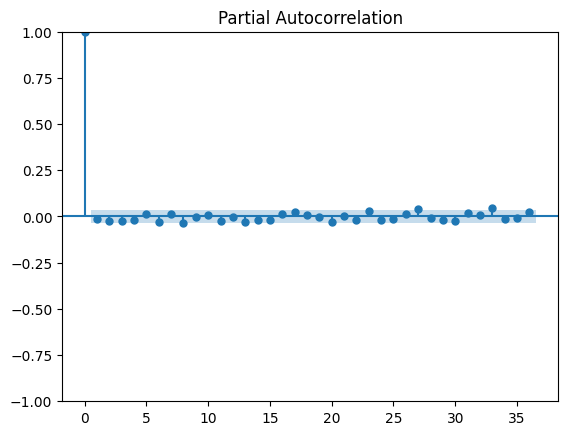

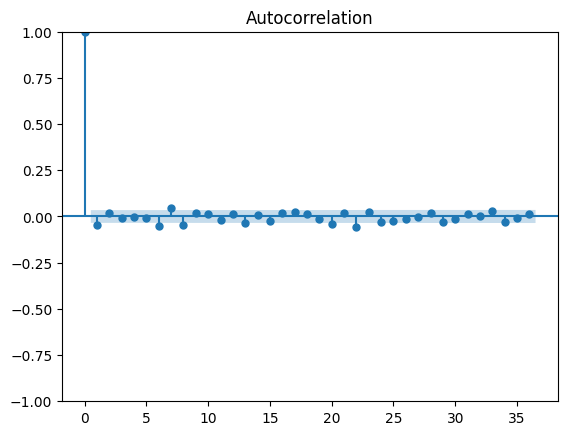

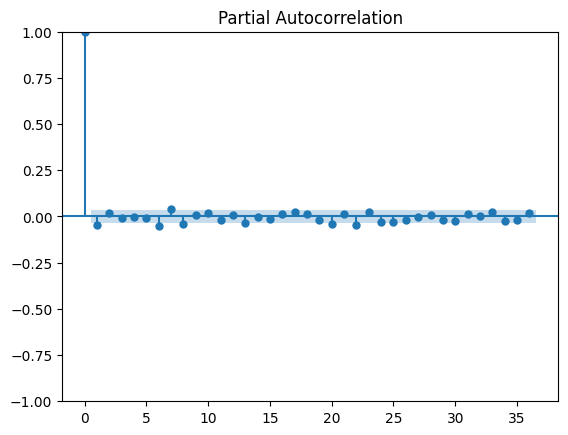

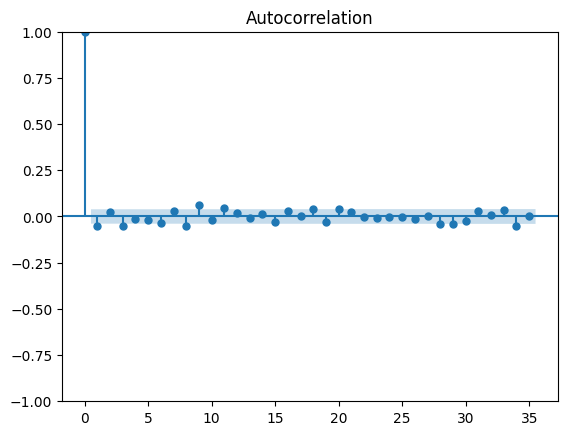

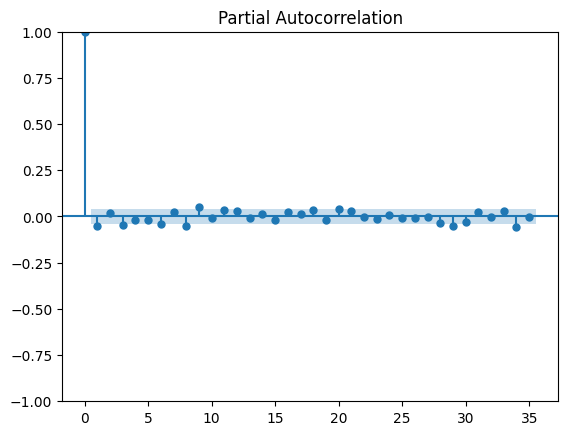

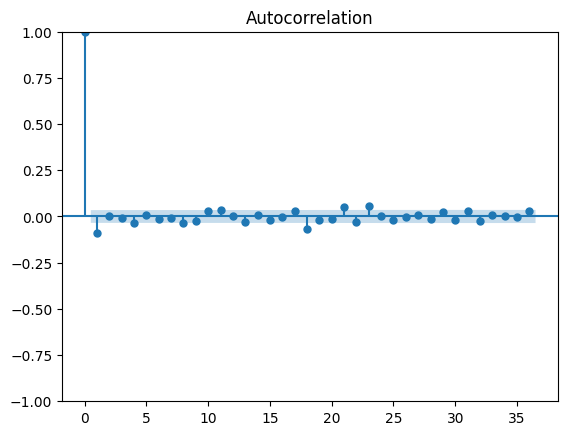

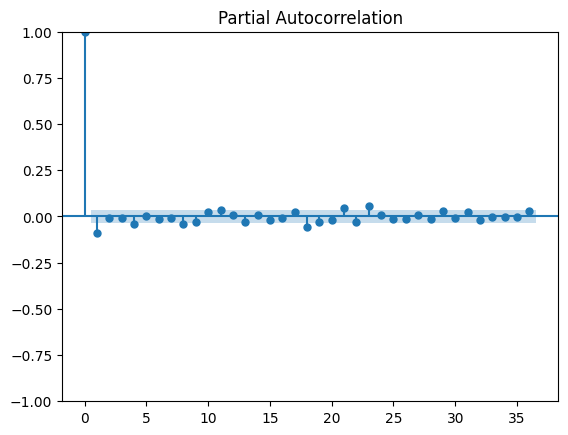

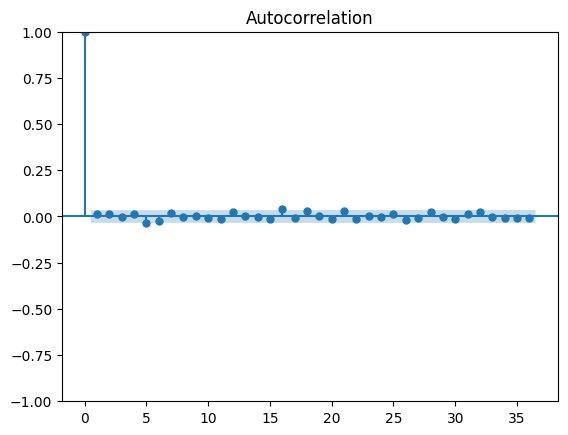

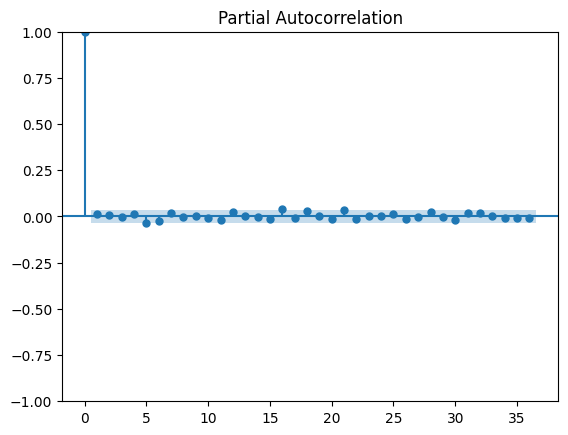

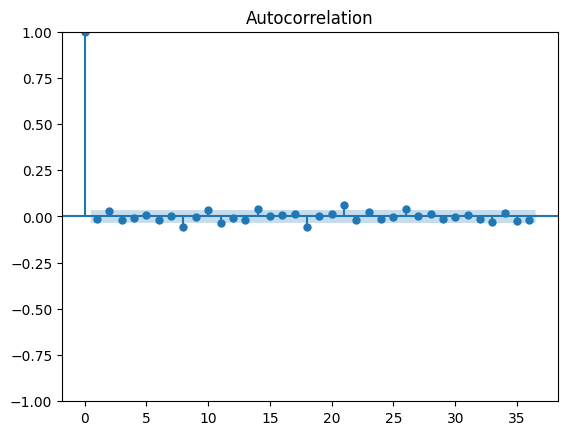

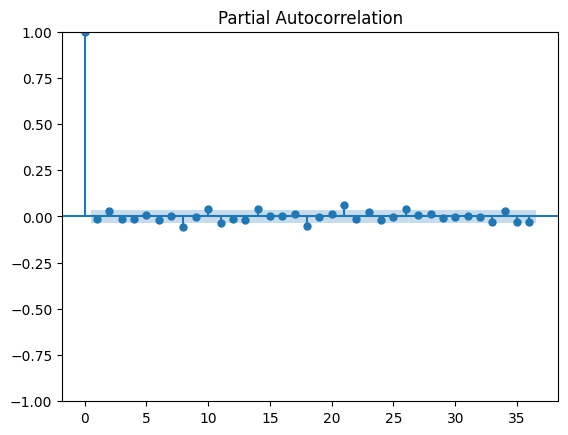

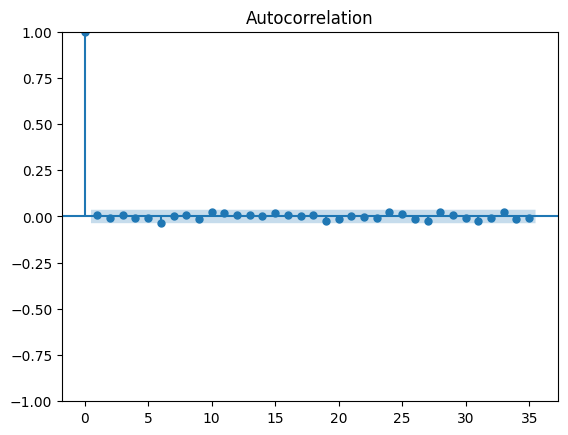

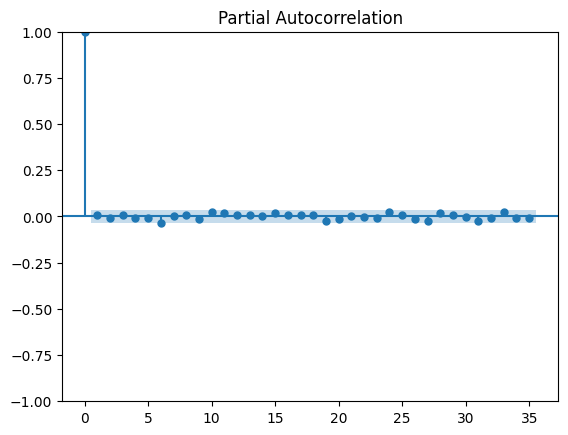

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)
for i, company in enumerate(df_dict):
    X = df_dict[company]['train']['Close']
    X_boxcox, _ = boxcox(X)
    X_boxcox_diff = diff(X_boxcox, k_diff=1)

    plot_acf(X_boxcox_diff)
    plot_pacf(X_boxcox_diff, method='ywm')

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


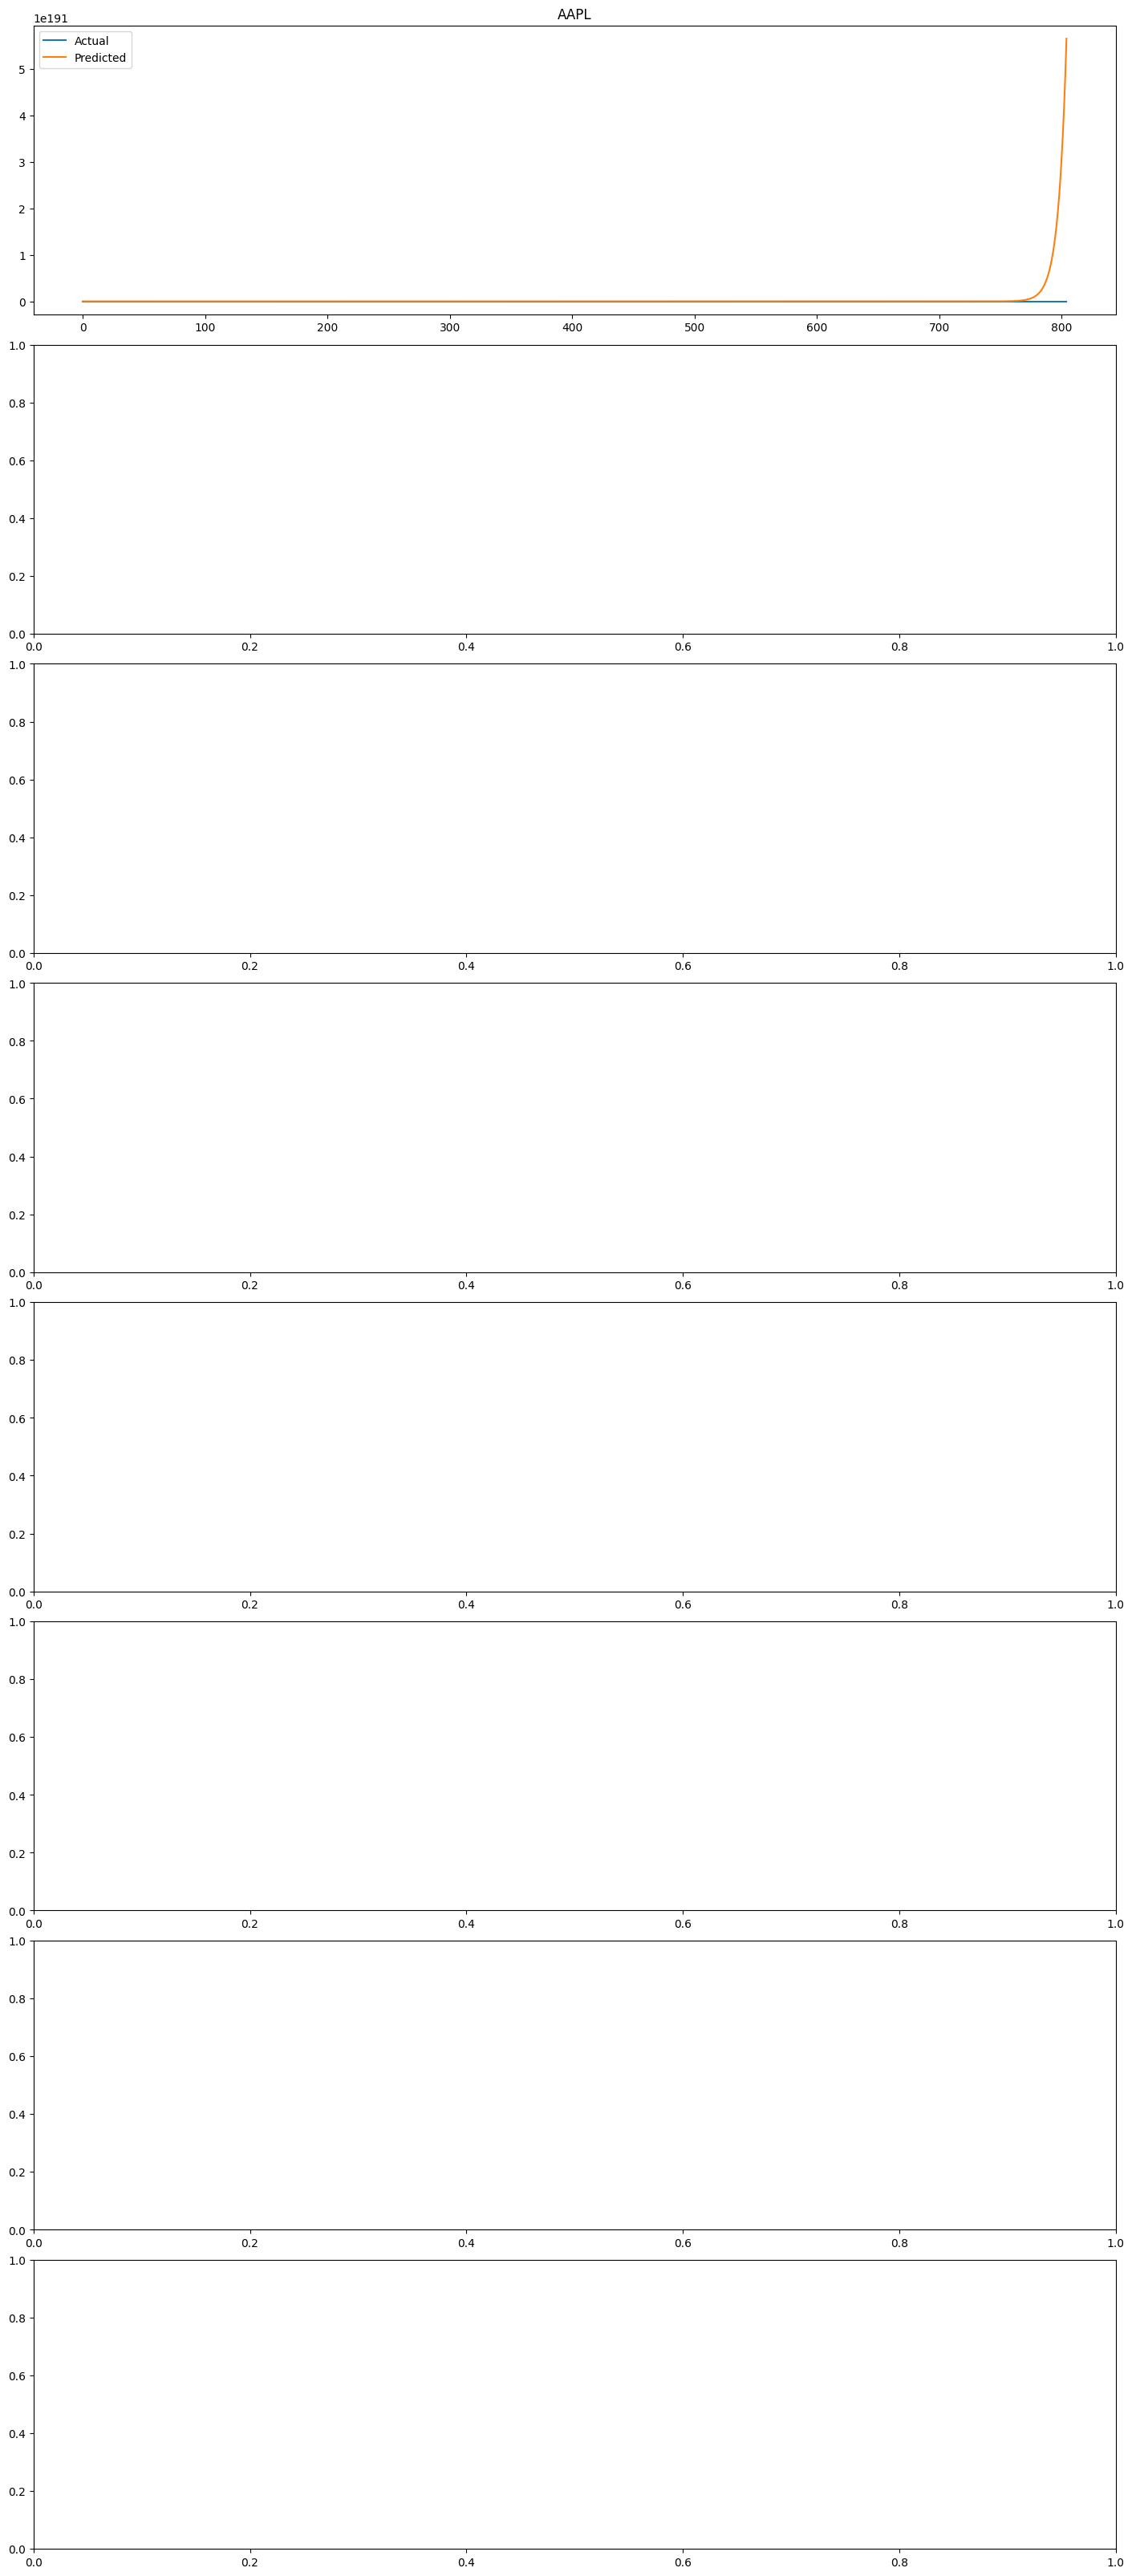

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox

fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)
for i, company in enumerate(df_dict):
    X_train = df_dict[company]['train']['Close'].to_numpy()
    X_test = df_dict[company]['test']['Close'].to_numpy()
    X_boxcox, lmbda = boxcox(X_train)

    model = ARIMA(X_boxcox, order=(8, 1, 8)).fit()
    predicted_boxcox_diff = model.forecast(len(X_test))

    predicted_boxcox = predicted_boxcox_diff.cumsum() + X_boxcox[-1]
    predicted = inv_boxcox(predicted_boxcox, lmbda)

    axs[i].plot(X_test, label="Actual")
    axs[i].plot(predicted, label="Predicted")
    axs[i].set_title(f'{company}')
    axs[i].legend()
    break

# Machine Learning (Random Forest)

In [57]:
from statsmodels.tsa.statespace.tools import diff
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [21]:
# AAPL raw train, test price
AAPL_train = df_dict['AAPL']['train']['Close'].to_numpy()
AAPL_test = df_dict['AAPL']['test']['Close'].to_numpy()

In [22]:
# boxcox and differencing
AAPL_train_boxcox, lmbda = boxcox(AAPL_train)
AAPL_train_boxcox_diff = diff(AAPL_train_boxcox, k_diff=1)

AAPL_test_boxcox = boxcox(AAPL_test, lmbda)
AAPL_test_boxcox_diff = diff(AAPL_test_boxcox, k_diff=1)

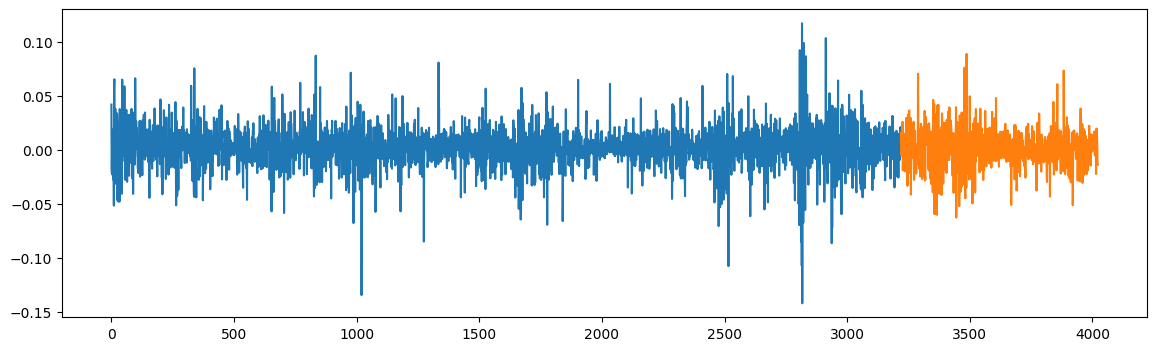

In [24]:
# showing boxcox and differencing makes data stationary
train_idx = np.arange(len(AAPL_train_boxcox_diff))
test_idx = np.arange(len(AAPL_train_boxcox_diff), len(AAPL_train_boxcox_diff) + len(AAPL_test_boxcox_diff))
plt.figure(figsize=(14, 4))
plt.plot(train_idx, AAPL_train_boxcox_diff)
plt.plot(test_idx, AAPL_test_boxcox_diff)

In [39]:
# inverse transform back to raw data
AAPL_train_boxcox_t = AAPL_train_boxcox[0] + AAPL_train_boxcox_diff.cumsum()
AAPL_train_boxcox_t = np.insert(AAPL_train_boxcox_t, 0, AAPL_train_boxcox[0], axis=0)
AAPL_train_t = inv_boxcox(AAPL_train_boxcox_t, lmbda)

AAPL_test_boxcox_t = AAPL_test_boxcox[0] + AAPL_test_boxcox_diff.cumsum()
AAPL_test_boxcox_t = np.insert(AAPL_test_boxcox_t, 0, AAPL_test_boxcox[0], axis=0)
AAPL_test_t = inv_boxcox(AAPL_test_boxcox_t, lmbda)

In [41]:
# raw data and inverse transformed data should match
AAPL_data = np.concat((AAPL_train, AAPL_test), axis=0)
AAPL_data_t = np.concat((AAPL_train_t, AAPL_test_t), axis=0)
print(len(AAPL_data))
print(len(AAPL_data_t))
print(np.linalg.norm(AAPL_data - AAPL_data_t, ord=2))

4025
4025
1.7238743472702958e-12


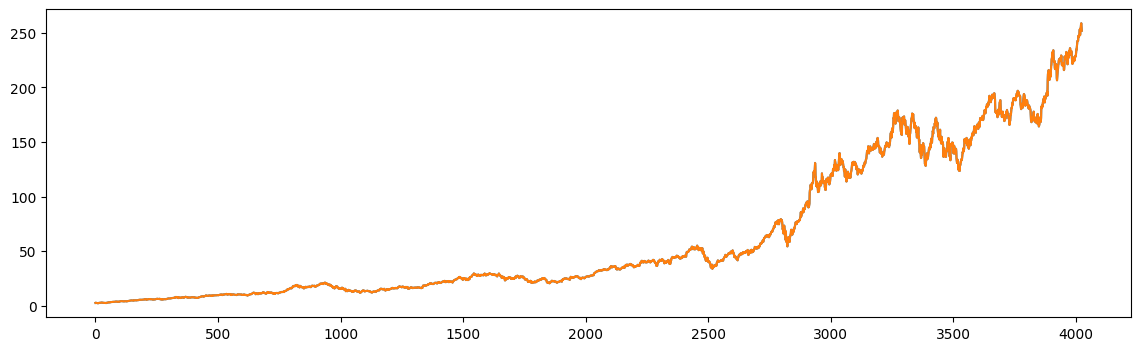

In [43]:
# plot raw data and inverse transformed data
plt.figure(figsize=(14, 4))
plt.plot(AAPL_data)
plt.plot(AAPL_data_t)

In [58]:
# create lag features
def create_dataset(data, n_lags):
    series = pd.Series(data)
    columns = []
    for i in range(n_lags, -1, -1):
        columns.append(series.shift(i).rename(f'lag{i}'))

    columns.append(series.shift(-1).rename('target'))
    df_lag = pd.concat(columns, axis=1)
    df_lag.dropna(inplace=True)

    X = df_lag.iloc[:, :-1]
    y = df_lag.iloc[:, -1]

    return X.to_numpy(), y.to_numpy()

In [59]:
# create lag features
AAPL_X_train, AAPL_y_train = create_dataset(AAPL_train_boxcox_diff, 2)
print(AAPL_train_boxcox_diff[:10])
print(AAPL_X_train)
print(AAPL_y_train)

AAPL_X_test, AAPL_y_test = create_dataset(AAPL_test_boxcox_diff, 2)

[ 0.04167572 -0.01676911 -0.02202279  0.01854858 -0.02332212 -0.02159397
 -0.01085697 -0.02772022 -0.02328892 -0.01276553]
[[ 0.04167572 -0.01676911 -0.02202279]
 [-0.01676911 -0.02202279  0.01854858]
 [-0.02202279  0.01854858 -0.02332212]
 ...
 [-0.002835   -0.0006552  -0.00951013]
 [-0.0006552  -0.00951013 -0.00441909]
 [-0.00951013 -0.00441909  0.02082527]]
[ 0.01854858 -0.02332212 -0.02159397 ... -0.00441909  0.02082527
  0.00778488]


In [70]:
# train random forest
model = RandomForestRegressor(n_estimators=500, max_depth=30)
model.fit(AAPL_X_train, AAPL_y_train)

RandomForestRegressor(max_depth=30, n_estimators=500)

In [80]:
# predict
y_pred = model.predict(AAPL_X_test).flatten()
MSE = mean_squared_error(y_pred, AAPL_y_test)

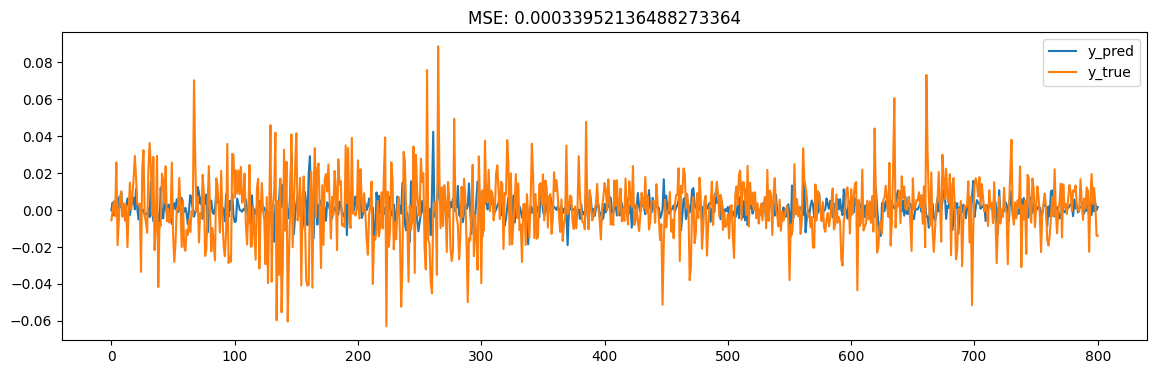

In [81]:
# plot y_pred and y_true
plt.figure(figsize=(14, 4))
plt.plot(y_pred, label="y_pred")
plt.plot(AAPL_y_test, label="y_true")
plt.title(f"MSE: {MSE}")
plt.legend()

In [86]:
# inverse transform back to raw data
AAPL_y_pred_boxcox_diff = np.concat((AAPL_test_boxcox_diff[:3], y_pred), axis=0)
AAPL_y_test_boxcox_diff = np.concat((AAPL_test_boxcox_diff[:3], AAPL_y_test), axis=0)

AAPL_y_pred_boxcox_t = AAPL_test_boxcox[0] + AAPL_y_pred_boxcox_diff.cumsum()
AAPL_y_pred_boxcox_t = np.insert(AAPL_y_pred_boxcox_t, 0, AAPL_test_boxcox[0], axis=0)
AAPL_y_pred_t = inv_boxcox(AAPL_y_pred_boxcox_t, lmbda)

AAPL_y_test_boxcox_t = AAPL_test_boxcox[0] + AAPL_y_test_boxcox_diff.cumsum()
AAPL_y_test_boxcox_t = np.insert(AAPL_y_test_boxcox_t, 0, AAPL_test_boxcox[0], axis=0)
AAPL_y_test_t = inv_boxcox(AAPL_y_test_boxcox_t, lmbda)

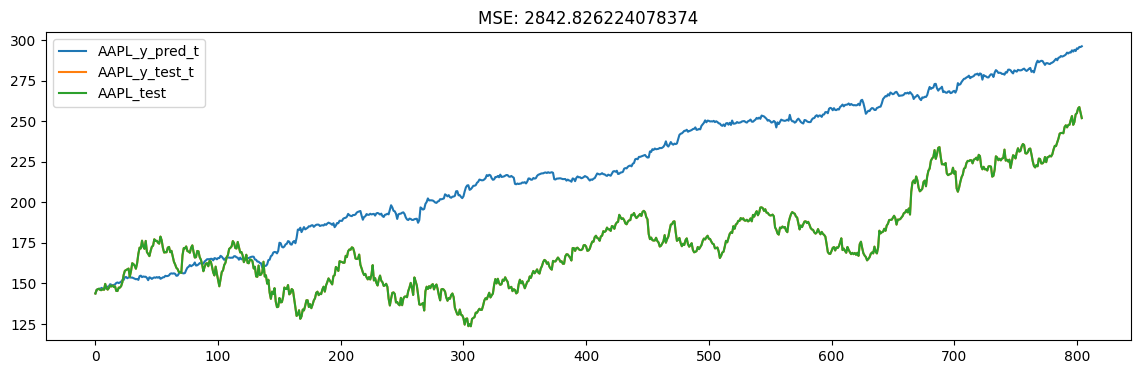

In [89]:
# plot inverse transformed y_pred and y_true and raw test data
plt.figure(figsize=(14, 4))
plt.plot(AAPL_y_pred_t, label="AAPL_y_pred_t")
plt.plot(AAPL_y_test_t, label="AAPL_y_test_t")
plt.plot(AAPL_test, label="AAPL_test")
MSE = mean_squared_error(AAPL_y_pred_t, AAPL_y_test_t)
plt.title(f"MSE: {MSE}")
plt.legend()

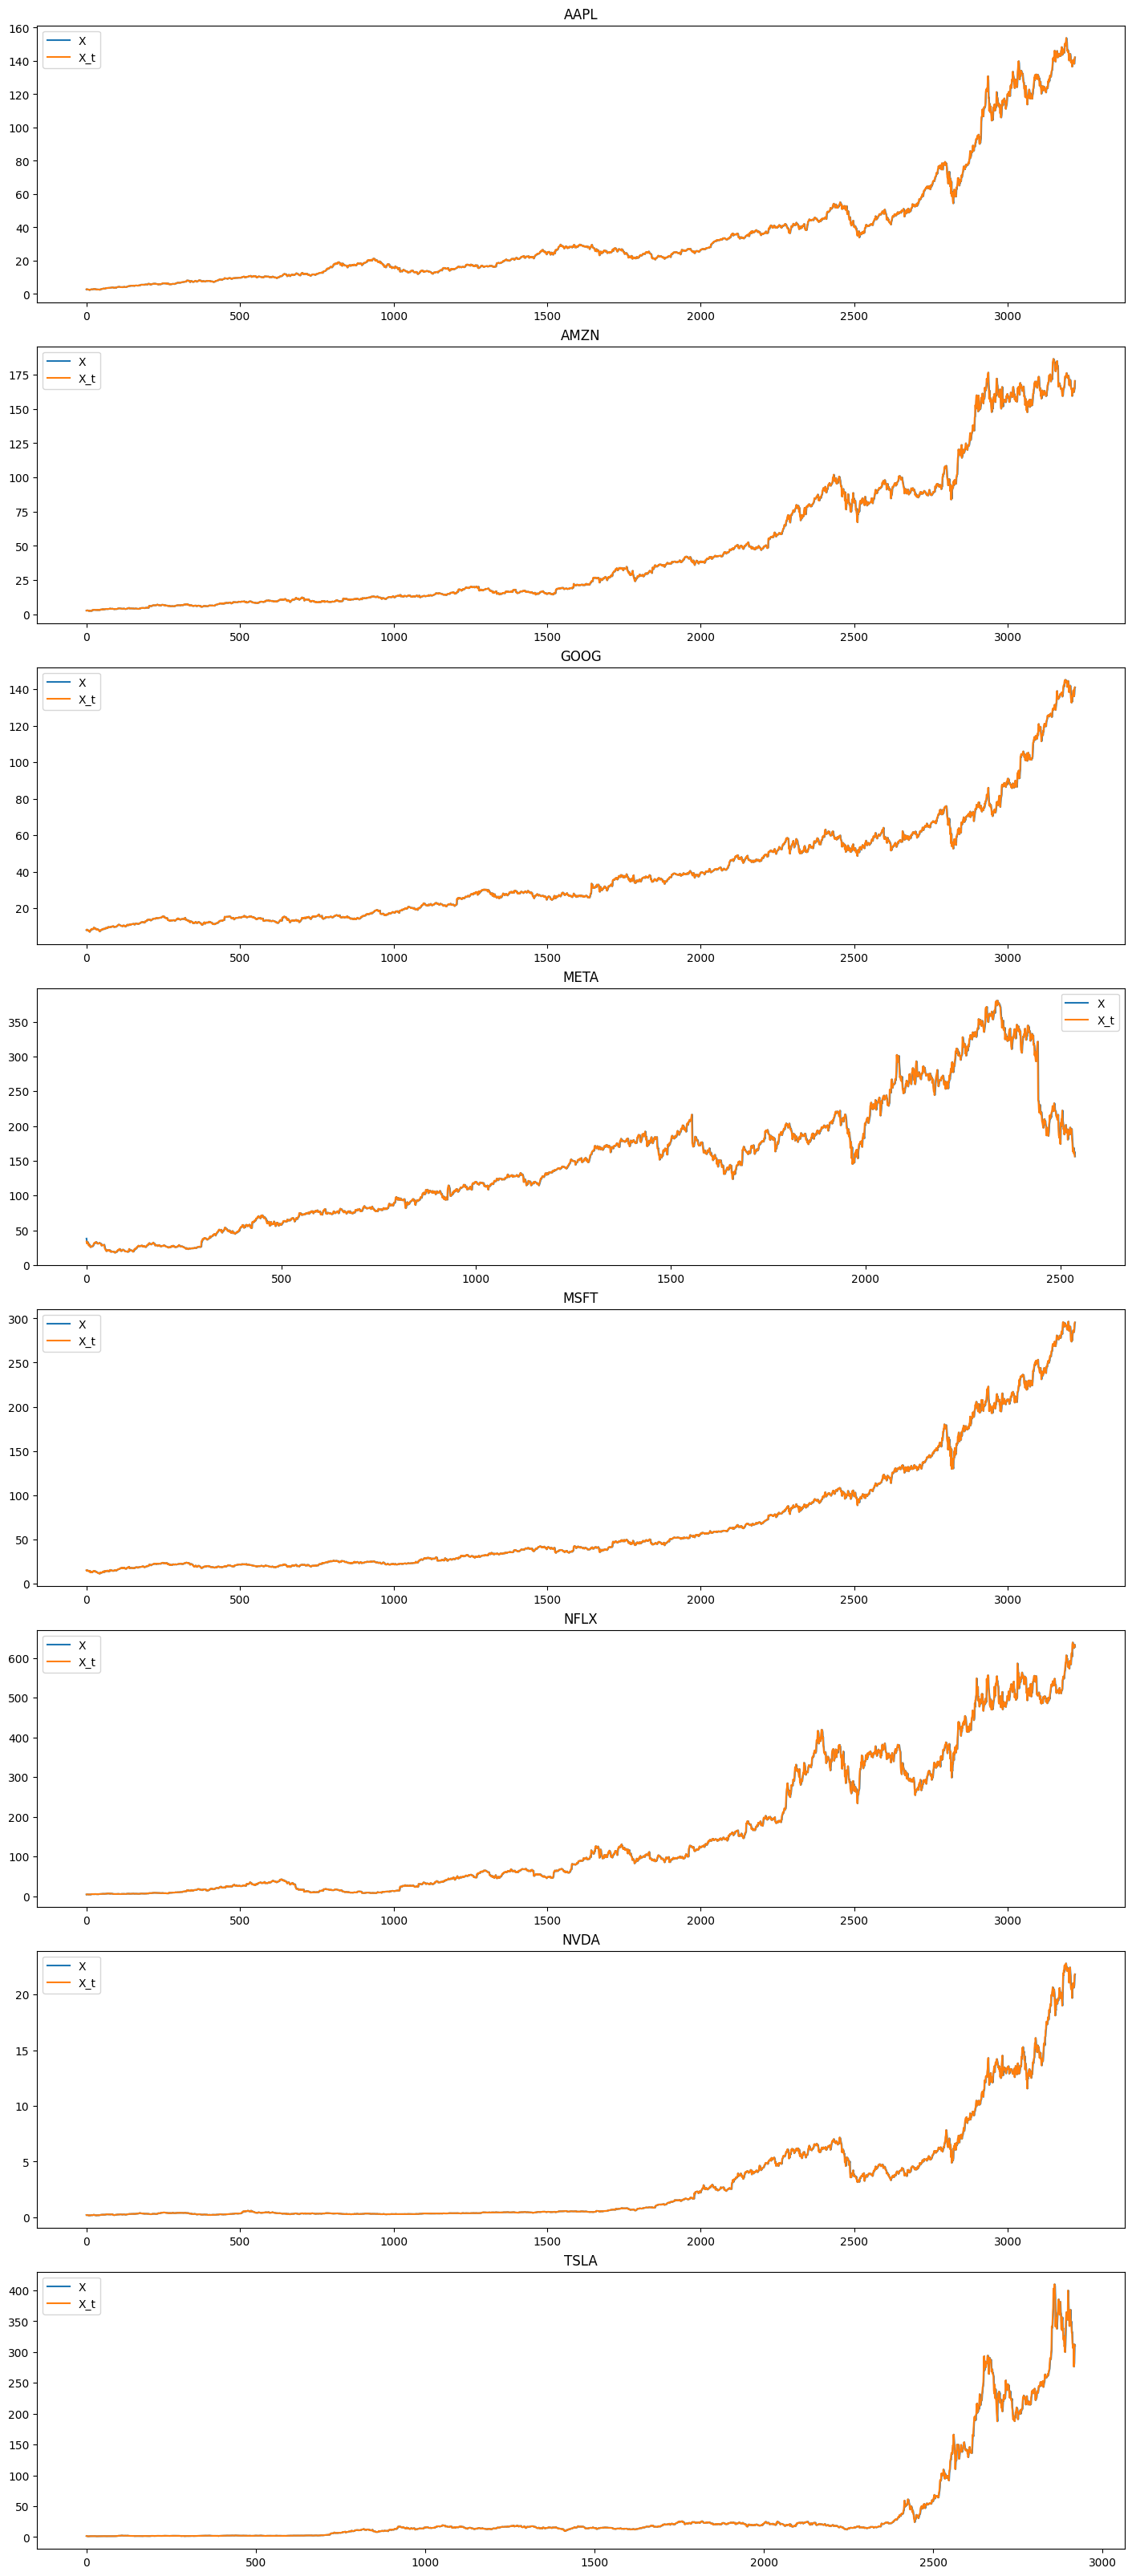

In [ ]:
fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)
for i, company in enumerate(df_dict):
    X = df_dict[company]['train']['Close'].to_numpy()

    X_boxcox, lmbda = boxcox(X + 1)
    X_boxcox_diff = diff(X_boxcox, k_diff=1)

    X_boxcox_t = X_boxcox[0] + X_boxcox_diff.cumsum()
    X_t = inv_boxcox(X_boxcox_t, lmbda) - 1

    axs[i].plot(X, label="X")
    axs[i].plot(X_t, label="X_t")
    axs[i].set_title(f'{company}')
    axs[i].legend()

In [ ]:
def create_dataset(df):
    df['target'] = df['Close'].shift(-1)
    df.dropna(inplace=True)

    X = df['Close']
    y = df['target']

    return X.to_numpy().reshape(-1, 1), y.to_numpy().reshape(-1, 1)

X = df_dict['AAPL']['train']['Close'].to_numpy()
X_train_true, y_train_true = create_dataset(pd.DataFrame(X, columns=['Close']))

X = df_dict['AAPL']['train']['Close'].to_numpy()
X_boxcox, lmbda = boxcox(X + 1)
X_boxcox_diff = diff(X_boxcox, k_diff=1)
X_train, y_train = create_dataset(pd.DataFrame(X_boxcox_diff, columns=['Close']))


X_boxcox_t = X_boxcox[0] + X_train.cumsum()
X_t = inv_boxcox(X_boxcox_t, lmbda) - 1

print(X_t)
print(X_train_true)


# from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(n_estimators=100, max_depth=50)
# model.fit(X_train, y_train)

# predicted_boxcox_diff = model.predict(X_train).flatten()

# plt.figure(figsize=(14, 4))
# plt.plot(predicted_boxcox_diff)
# plt.plot(y_train)

# predicted_boxcox = predicted_boxcox_diff.cumsum()

# X_boxcox_t = X_boxcox[0] + X_boxcox_diff.cumsum()
# X_t = inv_boxcox(X_boxcox_t, lmbda) - 1

[  2.84625244   2.79930663   2.73881793 ... 138.87376404 138.28489685
 141.08181763]
[[  2.73099375]
 [  2.84625244]
 [  2.79930663]
 ...
 [138.87376404]
 [138.28489685]
 [141.08181763]]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# scale numeric columns for each company, as LSTM works better with normalized data
# store the scaler

scaler_dict = {}
df_scaled_dict = {}
numerical_columns = ['Close', 'High', 'Low', 'Open']

for company in df_dict:
    scaler = MinMaxScaler(feature_range=(0,1))
    train = df_dict[company]['train'].copy()
    test = df_dict[company]['test'].copy()
    train[numerical_columns] = scaler.fit_transform(train[numerical_columns])
    test[numerical_columns] = scaler.transform(test[numerical_columns])
    df_scaled_dict[company] = {'train': train, 'test': test}
    scaler_dict[company] = scaler

In [ ]:
df_scaled_dict

{'AAPL': {'train':             Ticker     Close      High       Low      Open  Sentiment
  Date                                                                 
  2009-01-02     0.0  0.002494  0.001791  0.001404  0.001288        1.0
  2009-01-05     0.0  0.003255  0.002810  0.002927  0.002734        1.0
  2009-01-06     0.0  0.002945  0.003006  0.002863  0.003286        1.0
  2009-01-07     0.0  0.002546  0.002081  0.002433  0.002464        1.0
  2009-01-08     0.0  0.002882  0.002210  0.002389  0.002191        1.0
  ...            ...       ...       ...       ...       ...        ...
  2021-10-11     0.0  0.910040  0.919545  0.917232  0.904818        1.0
  2021-10-12     0.0  0.901615  0.909464  0.912167  0.911030        1.0
  2021-10-13     0.0  0.897726  0.897509  0.900060  0.898153        1.0
  2021-10-14     0.0  0.916198  0.913535  0.915259  0.903782        1.0
  2021-10-15     0.0  0.923198  0.920127  0.928417  0.914524        1.0
  
  [3220 rows x 6 columns],
  'test':        

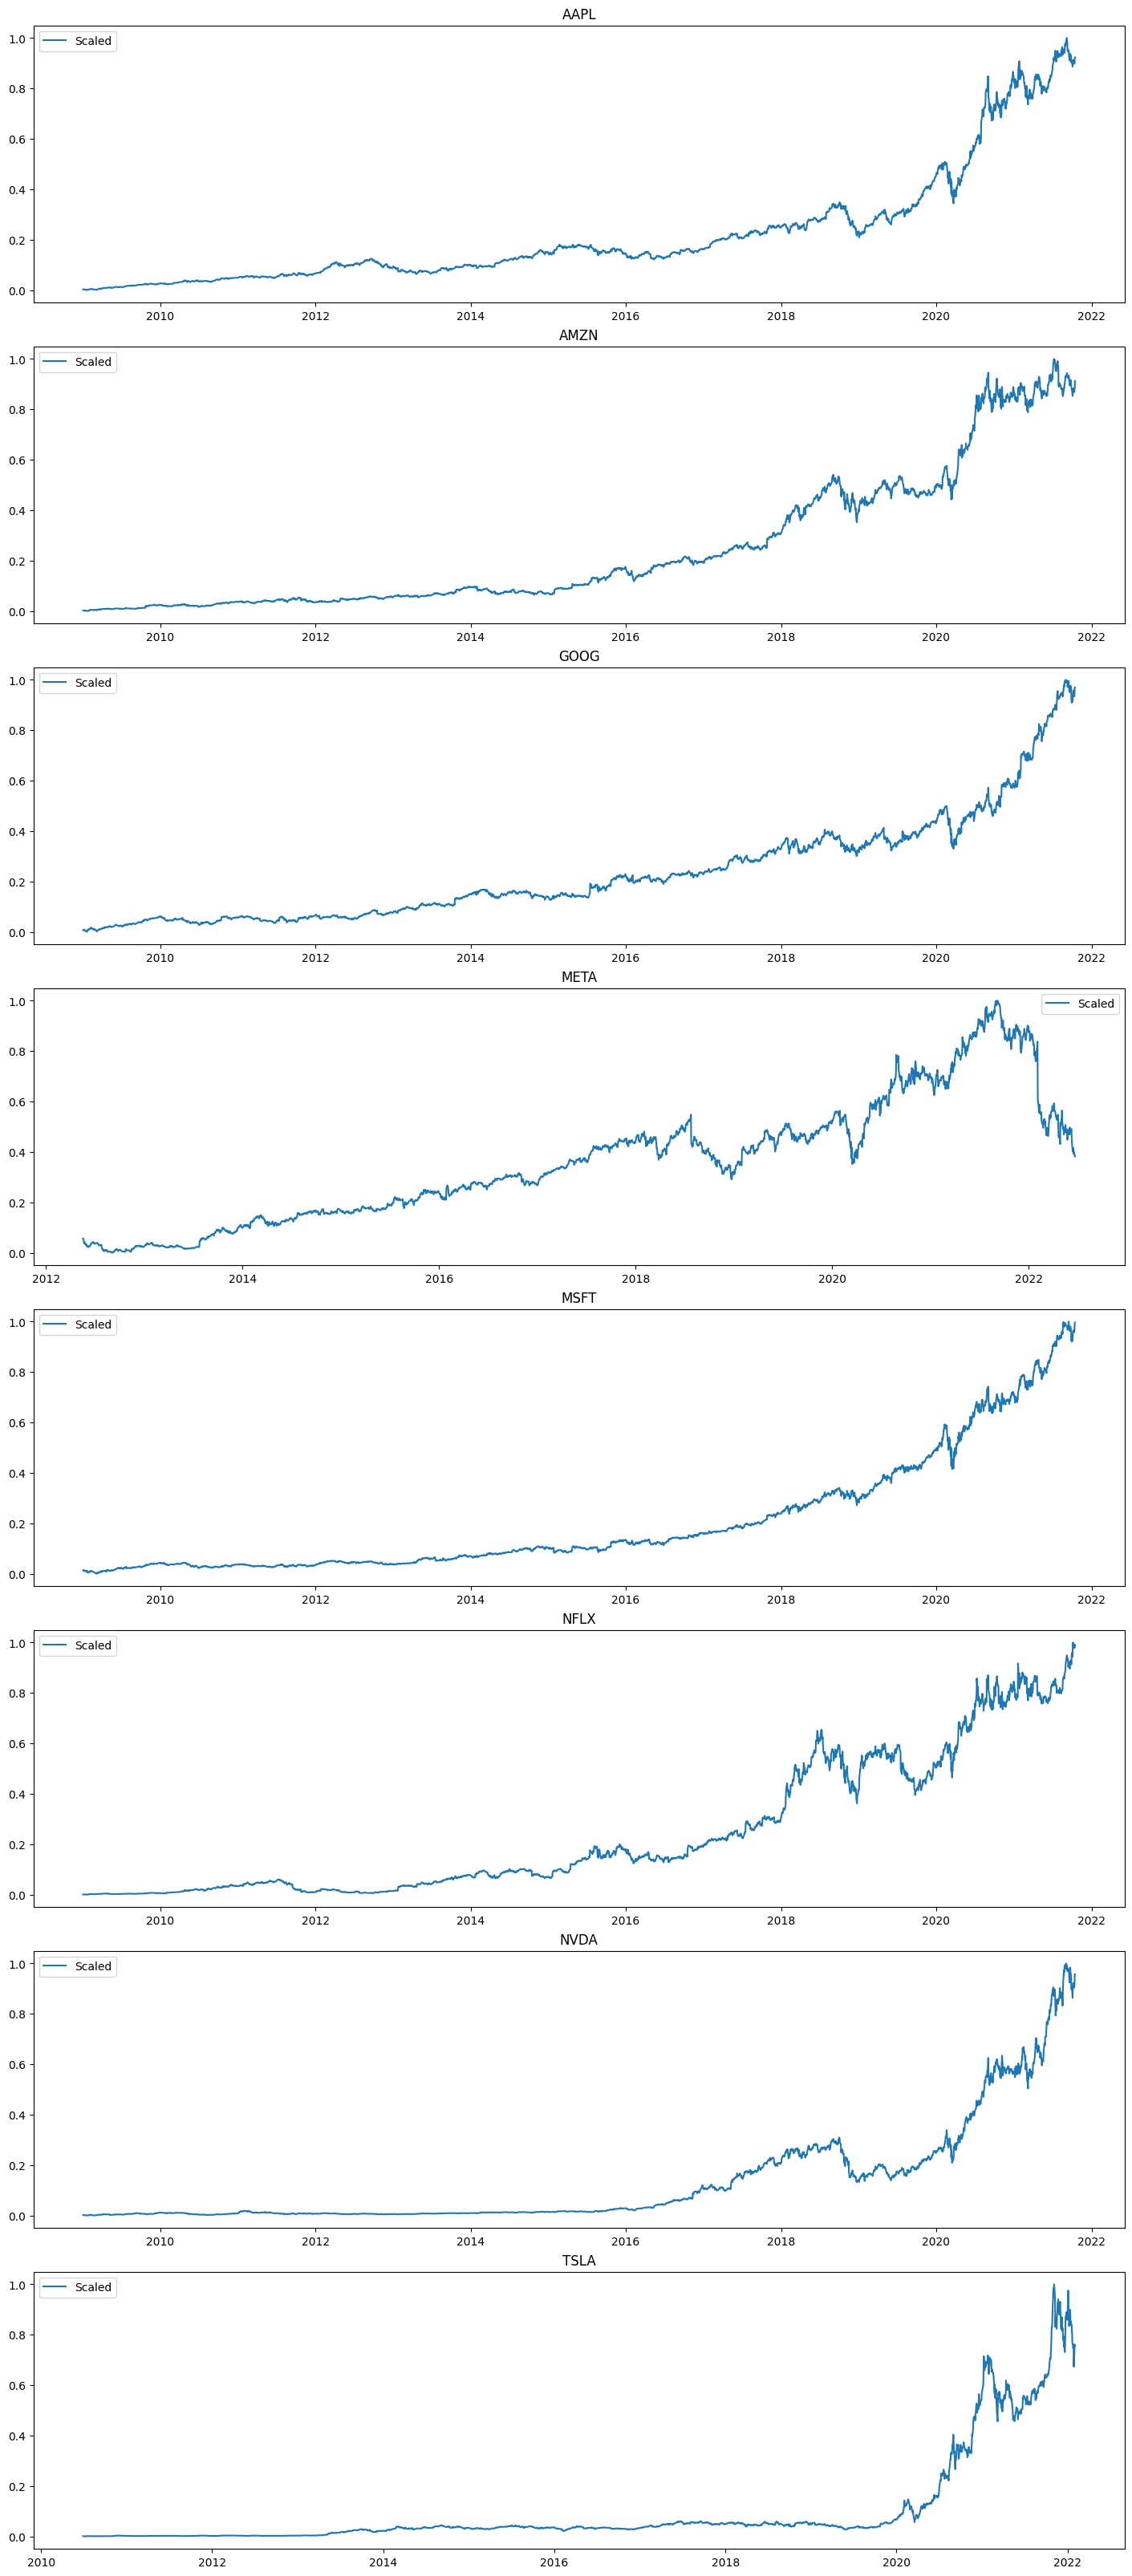

In [ ]:
fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)
for i, company in enumerate(df_scaled_dict):
    X = df_scaled_dict[company]['train']['Close']
    axs[i].plot(X, label="Scaled")
    axs[i].set_title(f'{company}')
    axs[i].legend()

In [ ]:
from statsmodels.tsa.statespace.tools import diff
from scipy.stats import boxcox

lmbda_dict = {}
df_stationary_dict = {}
X_test_boxcox_head_dict = {}

for company in df_scaled_dict:
    df_stationary_dict[company] = {}

    X_train = df_scaled_dict[company]['train']['Close'] + 1 # add 1 to make all data point positive since boxcox need positive data
    X_train_boxcox, lmbda = boxcox(X_train)
    X_train_boxcox_diff = diff(X_train_boxcox, k_diff=1)

    X_test = df_scaled_dict[company]['test']['Close'] + 1 # add 1 to make all data point positive since boxcox need positive data
    X_test_boxcox = boxcox(X_test, lmbda)
    X_test_boxcox_head_dict[company] = X_test_boxcox[0]
    X_test_boxcox_diff = diff(X_test_boxcox, k_diff=1)

    df_stationary_dict[company]['train'] = X_train_boxcox_diff
    df_stationary_dict[company]['test'] = X_test_boxcox_diff

    lmbda_dict[company] = lmbda

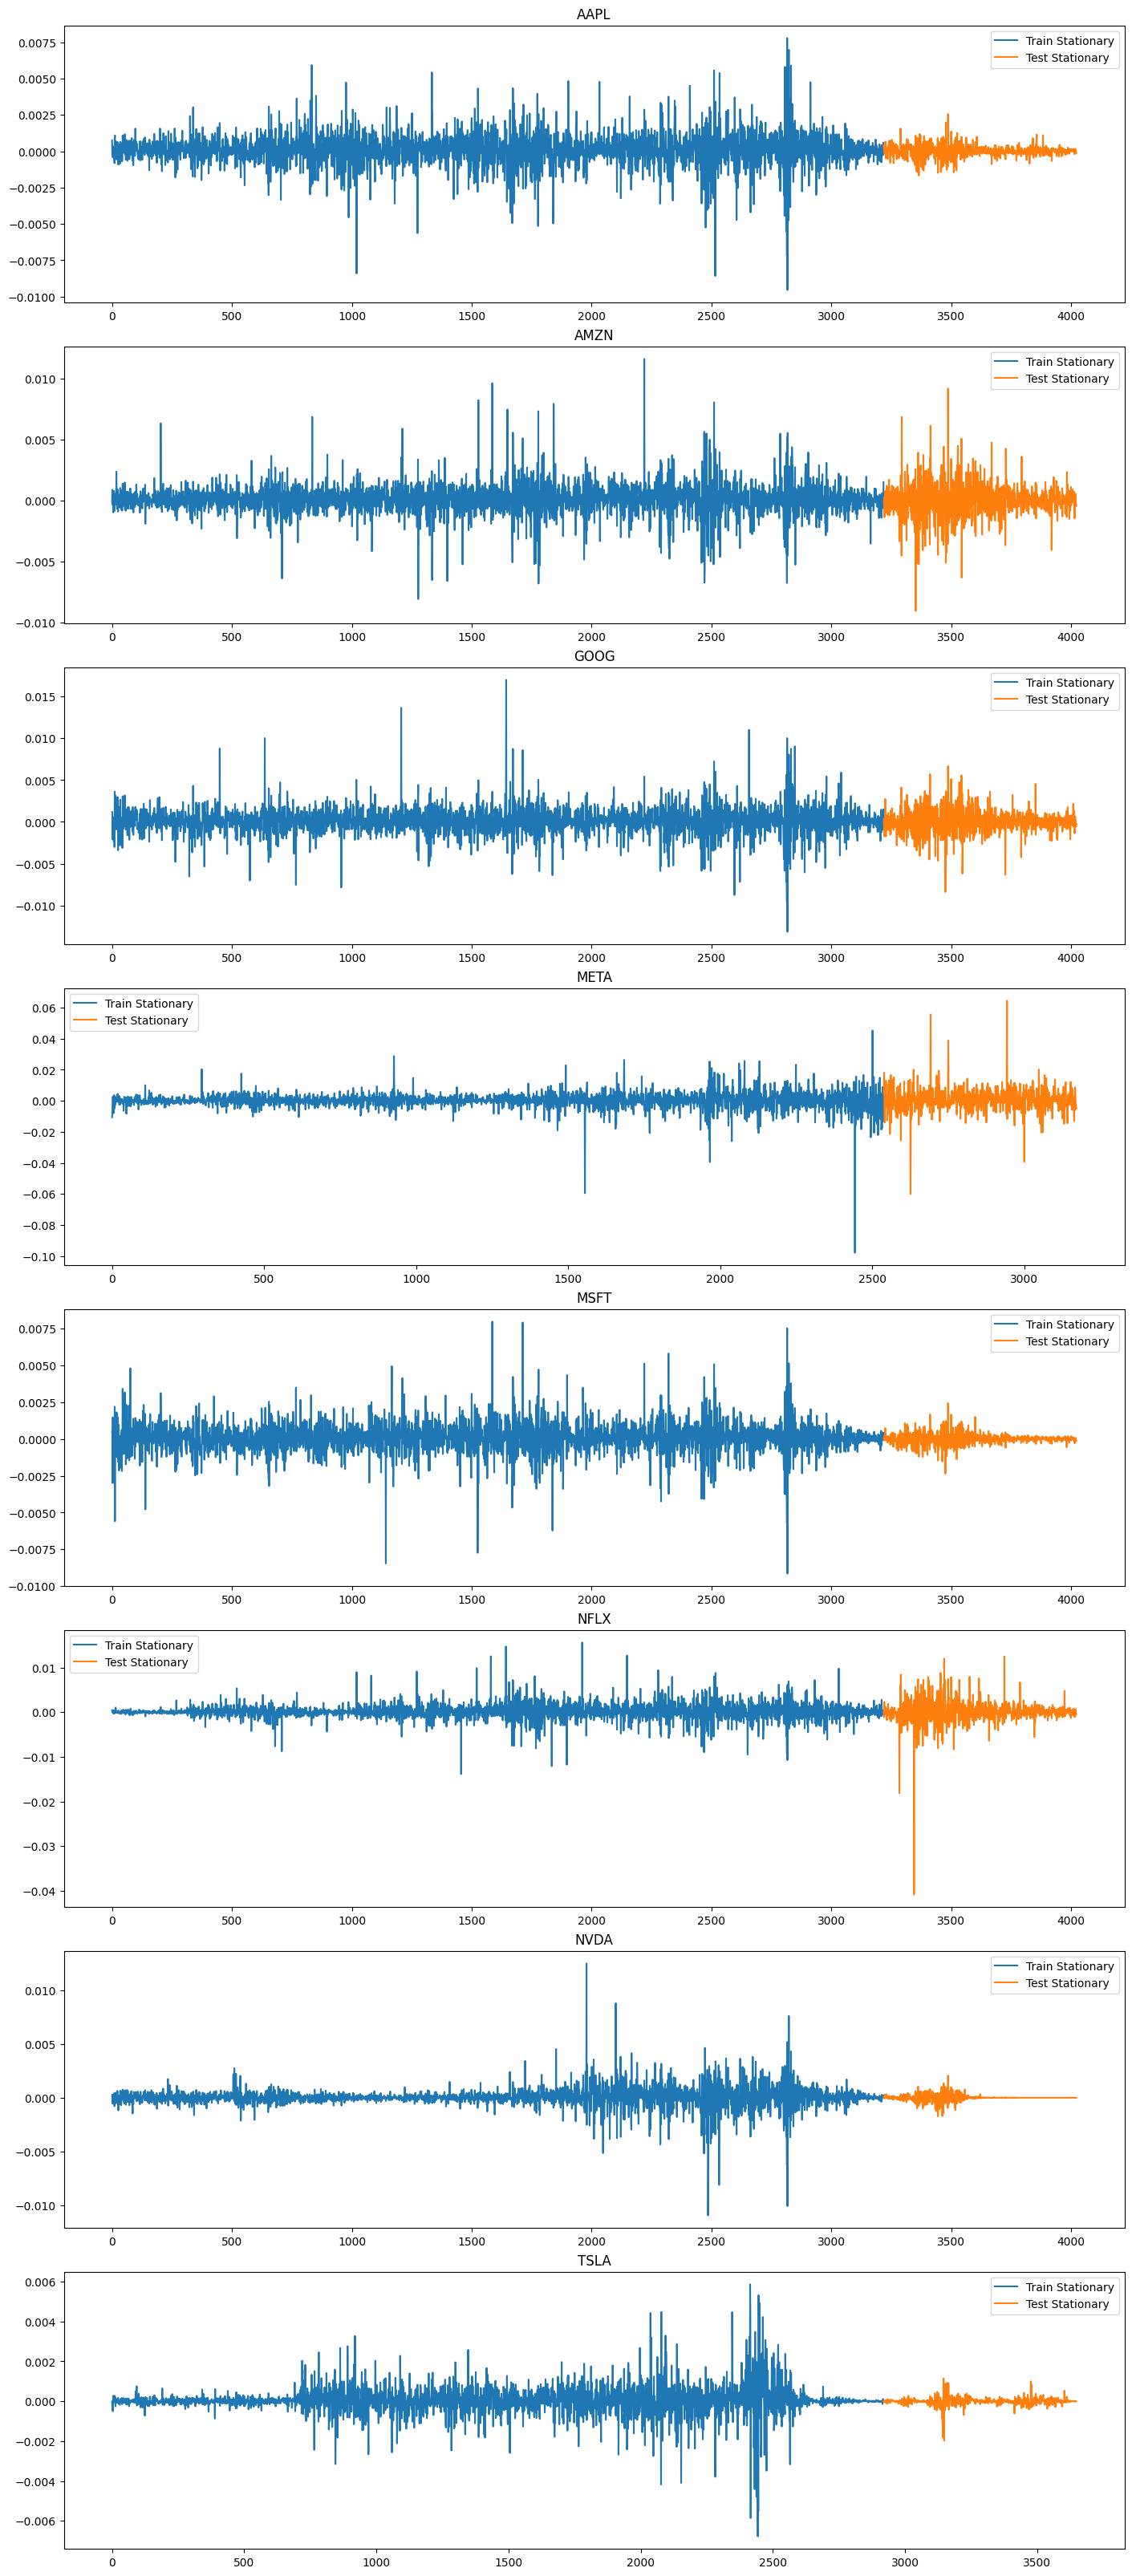

In [ ]:
fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)
for i, company in enumerate(df_stationary_dict):
    X_train = df_stationary_dict[company]['train']
    X_train_idx = np.arange(len(X_train))
    X_test = df_stationary_dict[company]['test']
    X_test_idx = np.arange(len(X_train), len(X_train) + len(X_test))
    axs[i].plot(X_train_idx, X_train, label="Train Stationary")
    axs[i].plot(X_test_idx, X_test, label="Test Stationary")
    axs[i].set_title(f'{company}')
    axs[i].legend()

In [ ]:
### FOR LAG + MULTI-FEATURES

# def create_dataset(df, n_lags):
#     columns = []
#     lag_columns = ["Close", "High", "Low", "Open", "Sentiment"]
#     for col in lag_columns:
#         for i in range(0, n_lags + 1):
#             columns.append(df[col].shift(i).rename(f'{col}_lag{i}'))

#     columns.append(df['Close'].shift(-1).rename('target'))
#     df_lag = pd.concat(columns, axis=1)
#     df_lag.dropna(inplace=True)

#     X = df_lag.iloc[:, :-1]
#     y = df_lag.iloc[:, -1]


#     return X, y

# X_train_dict, y_train_dict, X_test_dict, y_test_dict = {}, {}, {}, {}
# # keep track of size for input output dataset
# dataset_shape_df = {'X_train':[], 'y_train':[], 'X_test':[], 'y_test':[]}

# # create dataset for train and test for each company
# for company in df_scaled_dict:
#     X_train, y_train = create_dataset(df_scaled_dict[company]['train'], 5)
#     X_test, y_test = create_dataset(df_scaled_dict[company]['test'], 5)
#     X_train_dict[company] = X_train
#     y_train_dict[company] = y_train
#     X_test_dict[company] = X_test
#     y_test_dict[company] = y_test
#     dataset_shape_df['X_train'].append(X_train.shape)
#     dataset_shape_df['y_train'].append(y_train.shape)
#     dataset_shape_df['X_test'].append(X_test.shape)
#     dataset_shape_df['y_test'].append(y_test.shape)
#     break

In [ ]:
### FOR STATIONARY SINGLE FEATURE NO LAG

def create_dataset(df):
    df['target'] = df['Close'].shift(-1)
    df.dropna(inplace=True)

    X = df['Close']
    y = df['target']

    return X, y

X_train_dict, y_train_dict, X_test_dict, y_test_dict = {}, {}, {}, {}
# keep track of size for input output dataset
dataset_shape_df = {'X_train':[], 'y_train':[], 'X_test':[], 'y_test':[]}

# create dataset for train and test for each company
for company in df_stationary_dict:
    X_train, y_train = create_dataset(pd.DataFrame(df_stationary_dict[company]['train'], columns=['Close']))
    X_test, y_test = create_dataset(pd.DataFrame(df_stationary_dict[company]['test'], columns=['Close']))
    X_train_dict[company] = X_train
    y_train_dict[company] = y_train
    X_test_dict[company] = X_test
    y_test_dict[company] = y_test
    dataset_shape_df['X_train'].append(X_train.shape)
    dataset_shape_df['y_train'].append(y_train.shape)
    dataset_shape_df['X_test'].append(X_test.shape)
    dataset_shape_df['y_test'].append(y_test.shape)

In [ ]:
pd.DataFrame(dataset_shape_df, index=df_scaled_dict.keys())

X_train  y_train  X_test  y_test
AAPL  (3218,)  (3218,)  (803,)  (803,)
AMZN  (3218,)  (3218,)  (803,)  (803,)
GOOG  (3218,)  (3218,)  (803,)  (803,)
META  (2537,)  (2537,)  (633,)  (633,)
MSFT  (3218,)  (3218,)  (803,)  (803,)
NFLX  (3218,)  (3218,)  (803,)  (803,)
NVDA  (3218,)  (3218,)  (803,)  (803,)
TSLA  (2918,)  (2918,)  (729,)  (729,)

In [ ]:
X_train_dict['AAPL']

0       0.000750
1      -0.000305
2      -0.000394
3       0.000331
4      -0.000415
          ...   
3213   -0.000081
3214   -0.000019
3215   -0.000273
3216   -0.000128
3217    0.000597
Name: Close, Length: 3218, dtype: float64

In [ ]:
y_train_dict['AAPL']

0      -0.000305
1      -0.000394
2       0.000331
3      -0.000415
4      -0.000377
          ...   
3213   -0.000019
3214   -0.000273
3215   -0.000128
3216    0.000597
3217    0.000218
Name: target, Length: 3218, dtype: float64

In [ ]:
# combine all training samples
X_train = np.concatenate([X_train_dict[company] for company in X_train_dict], axis=0).reshape(-1, 1)
y_train = np.concatenate([y_train_dict[company] for company in y_train_dict], axis=0).reshape(-1, 1)

print(X_train.shape)
print(y_train.shape)

(24763, 1)
(24763, 1)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, max_depth=50)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=50)

In [ ]:
### FOR LAG + MULTI-FEATURES

# from sklearn.metrics import mean_squared_error

# fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)

# # visualize prediction by unscaling the data
# for i, company in enumerate(df_scaled_dict):
#     scaler = scaler_dict[company]
#     y_pred = model.predict(X_test_dict[company]).flatten()
#     y_true = y_test_dict[company]
#     # create dummy input matrix since we originally scaled on a matrix
#     dummy_pred = np.zeros(shape=(len(y_pred), 4))
#     dummy_pred[:, 0] = y_pred
#     dummy_true = np.zeros(shape=(len(y_true), 4))
#     dummy_true[:, 0] = y_true
#     y_pred_scaled = scaler.inverse_transform(dummy_pred)[:, 0]
#     y_true_scaled = scaler.inverse_transform(dummy_true)[:, 0]
#     MSE = mean_squared_error(y_pred_scaled, y_true_scaled)

#     axs[i].plot(y_pred_scaled)
#     axs[i].plot(y_true_scaled)
#     axs[i].set_title(f'{company} MSE = {MSE}')
#     # axs[i].set_xlabel('Date')
#     axs[i].set_ylabel('Price')
#     axs[i].legend(["pred", "true"])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWa

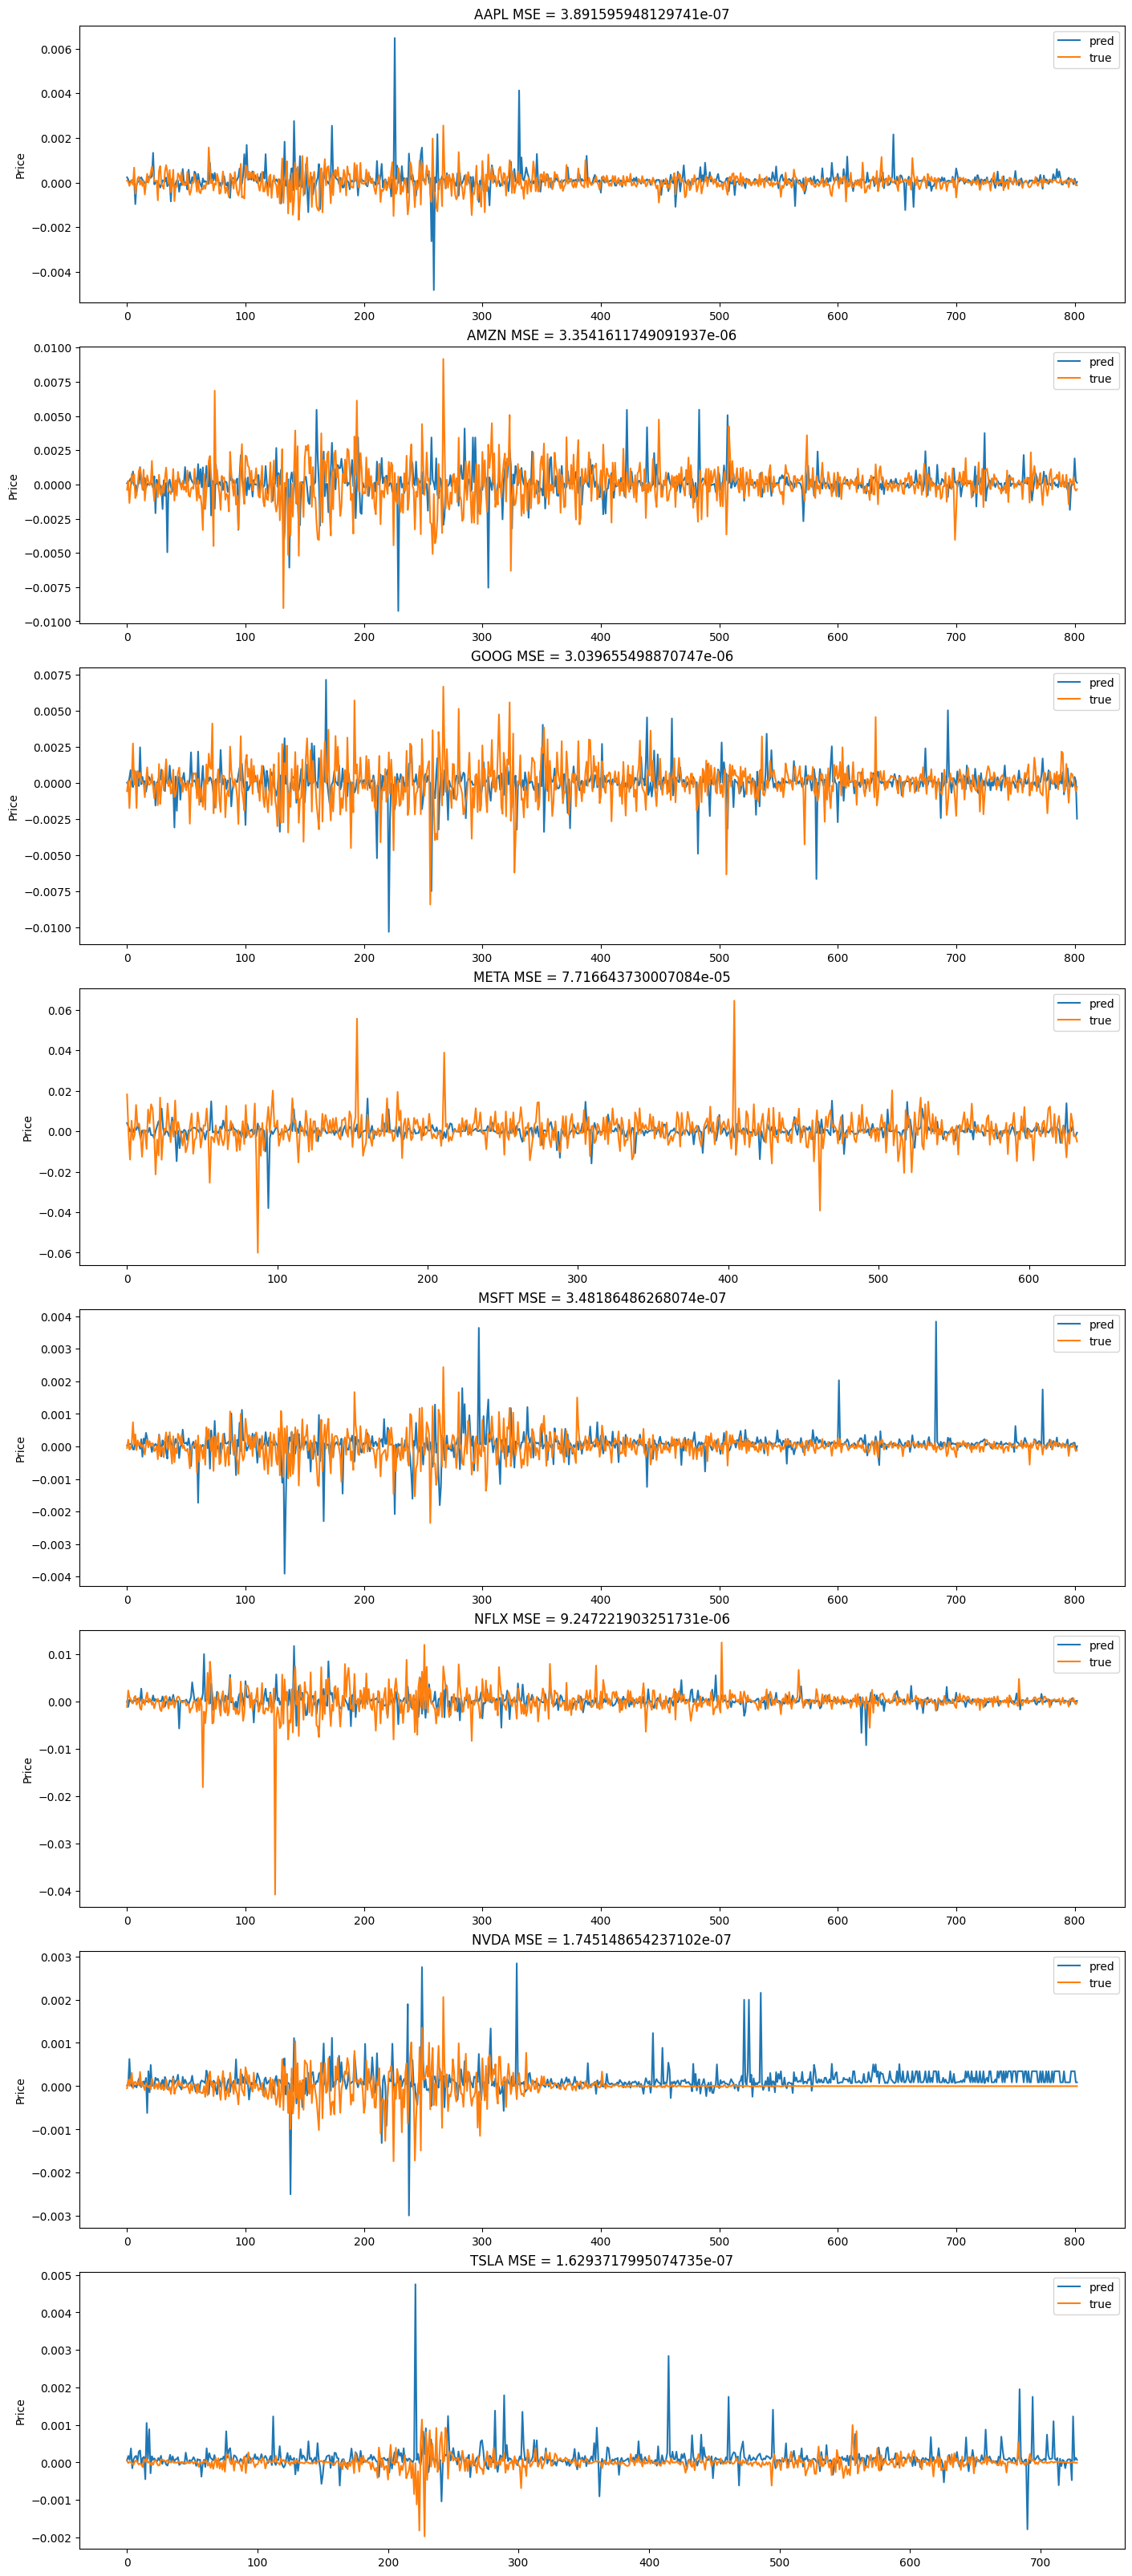

In [ ]:
### FOR STATIONARY SINGLE FEATURE NO LAG

from sklearn.metrics import mean_squared_error
from scipy.special import inv_boxcox

fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)

# visualize prediction by unscaling the data
for i, company in enumerate(df_stationary_dict):
    predicted_boxcox_diff = model.predict(X_test_dict[company].to_frame()).flatten()
    predicted_boxcox = predicted_boxcox_diff.cumsum() + X_test_boxcox_head_dict[company]
    predicted = inv_boxcox(predicted_boxcox, lmbda_dict[company])
    predicted -= 1

    true_boxcox_diff = y_test_dict[company]
    true_boxcox = true_boxcox_diff.cumsum() + X_test_boxcox_head_dict[company]
    true = inv_boxcox(true_boxcox, lmbda_dict[company])
    true -= 1

    # create dummy input matrix since we originally scaled on a matrix
    dummy_pred = np.zeros(shape=(len(predicted), 4))
    dummy_pred[:, 0] = predicted
    # dummy_true = np.zeros(shape=(len(y_true), 4))
    # dummy_true[:, 0] = y_true
    scaler = scaler_dict[company]
    predicted_scaled = scaler.inverse_transform(dummy_pred)[:, 0]
    # y_true_scaled = scaler.inverse_transform(dummy_true)[:, 0]

    MSE = mean_squared_error(predicted_boxcox_diff, true_boxcox_diff)

    axs[i].plot(predicted_boxcox_diff)
    axs[i].plot(true_boxcox_diff)
    axs[i].set_title(f'{company} MSE = {MSE}')
    # axs[i].set_title(f'{company}')
    axs[i].set_ylabel('Price')
    axs[i].legend(["pred", "true"])